# Customer LifeTime Value Project

The main objective of this project is to look at the historical margin and the churn probability of a customer and 
calculate the customer lifetime value for the company. There are certain assumptions that are taken into
consideration while performing the calculations like a uniform margin rate and fixed discounted rate at present value. 

### Importing Required Packages

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_regression
import statsmodels.api as sm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

In [4]:
#Setting up the working directory
os.chdir('/Users/nikhilviswanath/Documents/python_data/TP_data/')
os.getcwd()

'/Users/nikhilviswanath/Documents/python_data/TP_data'

### Reading the files into dataframes

In [5]:
churn_df = pd.read_csv(r'TP_churn_data.csv')
margin_df = pd.read_csv(r'TP_margin_data.csv')

In [6]:
demog_df=pd.read_csv(r'TP_demog_data.csv')

In [7]:
churn_df.shape, margin_df.shape, demog_df.shape

((240368, 31), (240368, 97), (240368, 11))

In [8]:
#churn_df.columns
margin_df.columns

Index(['trans_amt_t_minus_00', 'trans_amt_t_minus_01', 'trans_amt_t_minus_02', 'trans_amt_t_minus_03', 'trans_amt_t_minus_04', 'trans_amt_t_minus_05', 'trans_amt_t_minus_06', 'trans_amt_t_minus_07', 'trans_amt_t_minus_08', 'trans_amt_t_minus_09', 'trans_amt_t_minus_10', 'trans_amt_t_minus_11', 'trans_amt_t_minus_12', 'trans_amt_t_minus_13', 'trans_amt_t_minus_14', 'trans_amt_t_minus_15', 'trans_amt_t_minus_16', 'trans_amt_t_minus_17', 'trans_amt_t_minus_18', 'trans_amt_t_minus_19', 'trans_amt_t_minus_20', 'trans_amt_t_minus_21', 'trans_amt_t_minus_22', 'trans_amt_t_minus_23', 'trans_amt_t_minus_24', 'trans_amt_t_minus_25', 'trans_amt_t_minus_26', 'trans_amt_t_minus_27', 'trans_amt_t_minus_28', 'trans_amt_t_minus_29', 'trans_amt_t_minus_30', 'trans_amt_t_minus_31', 'trans_amt_t_minus_32', 'trans_amt_t_minus_33', 'trans_amt_t_minus_34', 'trans_amt_t_minus_35', 'trans_amt_t_plus_01', 'trans_amt_t_plus_02', 'trans_amt_t_plus_03', 'trans_amt_t_plus_04', 'trans_amt_t_plus_05',
       'trans_

#### Viewing records from the churn data

In [9]:
churn_df.head()

,ST,Zip,DMA,Area_Cd,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_cnt_life,purch_amt_life,purch_cnt_cc_36mo,purch_cnt_et_36mo,purch_cnt_ck_36mo,purch_cnt_tt_36mo,purch_amt_36mo,purch_avg_36mo,purch_avg_interval,mail_cnt_36mo,resp_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,order_cnt_36mo,tier,tier_prev,acct_ID,activation_date,event_date,churn_year_plus1_ind
0,SC,29607,567,864,1,1,1,0,0,3,21,5,145.0,4,0,1,5,145.0,29.00,4.50,5,0,0,1,1,1-Bronze,xxx,I148760611,30NOV12,31MAY15,1
1,MO,63901,632,573,1,1,1,0,0,9,9,1,20.0,0,0,1,1,20.0,20.00,-1.00,1,0,1,0,1,1-Bronze,xxx,I151076142,29NOV13,29NOV14,1
2,IL,60456,602,missing,0,1,1,0,0,1,167,102,2890.0,0,0,17,17,600.0,35.29,3.07,17,2,0,0,4,1-Bronze,xxx,I27001315,05OCT00,NaN,0
3,FL,34698,539,727,1,1,1,0,0,9,13,5,420.0,5,0,0,5,420.0,84.00,1.00,5,0,1,1,3,3-Gold,xxx,I150064127,31JUL13,29NOV14,1
4,CA,92084,825,760,0,1,1,0,0,1,2,2,120.0,1,0,1,2,120.0,60.00,1.00,2,0,0,0,2,1-Bronze,xxx,I152631565,30JUN14,NaN,0


In [10]:
#looking at summary stats for the churn data
print("The Summary statistics for Churn data")
print(churn_df.describe().T)

The Summary statistics for Churn data
                             count     mean       std  min     25%     50%      75%       max
emailable                 240368.0     0.51      0.50  0.0    0.00    1.00     1.00  1.00e+00
solicit_ph_ind            240368.0     0.89      0.31  0.0    1.00    1.00     1.00  1.00e+00
solicit_email_ind         240368.0     0.96      0.19  0.0    1.00    1.00     1.00  1.00e+00
fixd_incm_flg             240368.0     0.09      0.29  0.0    0.00    0.00     0.00  1.00e+00
scheduled_purchase_flg    240368.0     0.26      0.44  0.0    0.00    0.00     1.00  1.00e+00
months_since_last_trans   240368.0     2.92      3.11  1.0    1.00    1.00     4.00  1.20e+01
months_since_first_trans  240368.0    65.44     58.15  1.0   14.00   46.00   110.00  2.90e+02
purch_cnt_life            240368.0    55.94     75.66  1.0    8.00   26.00    73.00  2.64e+03
purch_amt_life            240368.0  3334.91  21698.76  0.0  220.00  800.96  2695.00  5.50e+06
purch_cnt_cc_36mo     

In [11]:
#Checking for Null values in churn data
churn_df.isnull().sum() #we can see null values for event date in the churn data

ST                               0
Zip                              0
DMA                              0
Area_Cd                          0
emailable                        0
solicit_ph_ind                   0
solicit_email_ind                0
fixd_incm_flg                    0
scheduled_purchase_flg           0
months_since_last_trans          0
months_since_first_trans         0
purch_cnt_life                   0
purch_amt_life                   0
purch_cnt_cc_36mo                0
purch_cnt_et_36mo                0
purch_cnt_ck_36mo                0
purch_cnt_tt_36mo                0
purch_amt_36mo                   0
purch_avg_36mo                   0
purch_avg_interval               0
mail_cnt_36mo                    0
resp_cnt_36mo                    0
call_in_mo_36mo                  0
call_out_mo_36mo                 0
order_cnt_36mo                   0
tier                             0
tier_prev                        0
acct_ID                          0
activation_date     

#### Analyzing the margin dataframe


In [12]:
margin_df.head()

,trans_amt_t_minus_00,trans_amt_t_minus_01,trans_amt_t_minus_02,trans_amt_t_minus_03,trans_amt_t_minus_04,trans_amt_t_minus_05,trans_amt_t_minus_06,trans_amt_t_minus_07,trans_amt_t_minus_08,trans_amt_t_minus_09,trans_amt_t_minus_10,trans_amt_t_minus_11,trans_amt_t_minus_12,trans_amt_t_minus_13,trans_amt_t_minus_14,trans_amt_t_minus_15,trans_amt_t_minus_16,trans_amt_t_minus_17,trans_amt_t_minus_18,trans_amt_t_minus_19,trans_amt_t_minus_20,trans_amt_t_minus_21,trans_amt_t_minus_22,trans_amt_t_minus_23,trans_amt_t_minus_24,...,cost_amt_t_minus_11,cost_amt_t_minus_10,cost_amt_t_minus_09,cost_amt_t_minus_08,cost_amt_t_minus_07,cost_amt_t_minus_06,cost_amt_t_minus_05,cost_amt_t_minus_04,cost_amt_t_minus_03,cost_amt_t_minus_02,cost_amt_t_minus_01,cost_amt_t_minus_00,cost_amt_t_plus_01,cost_amt_t_plus_02,cost_amt_t_plus_03,cost_amt_t_plus_04,cost_amt_t_plus_05,cost_amt_t_plus_06,cost_amt_t_plus_07,cost_amt_t_plus_08,cost_amt_t_plus_09,cost_amt_t_plus_10,cost_amt_t_plus_11,cost_amt_t_plus_12,acct_ID
0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,50.0,0.0,40.0,0.0,20.0,0.0,0.0,0.0,0.0,...,0.00,0.56,0.24,0.56,0.29,0.23,0.52,0.80,2.41,2.71,0.82,0.64,1.76,0.60,1.69,0.30,0.82,0.30,0.82,0.00,0.56,0.00,1.09,0.56,I148760611
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,12.48,1.33,0.00,0.00,0.52,0.80,0.00,0.26,0.52,0.00,0.82,0.00,0.79,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,I151076142
2,25.0,0.0,0.0,50.0,30.0,0.0,60.0,30.0,0.0,140.0,0.0,25.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,35.0,0.0,...,1.07,0.56,4.83,0.48,1.07,2.37,0.00,1.87,1.37,2.65,0.26,1.37,1.89,1.37,1.69,1.37,0.82,1.07,1.59,1.07,1.93,3.41,1.59,1.93,I27001315
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,84.0,84.0,84.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.70,5.16,3.29,1.80,0.94,0.94,4.95,0.80,0.30,2.91,0.26,0.84,1.72,0.30,0.00,0.00,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.30,I150064127
4,20.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.79,1.07,1.67,2.14,1.99,1.37,0.82,0.60,1.42,0.00,0.56,0.56,2.60,0.86,I152631565


In [13]:
#margin_df.isnull().sum() #no missing data in margin data

### Modifying the margin data to ensure only yearly margina numbers is present.
Margin= (Revenue - Cost)

In [14]:
margin_df['rev_Y_neg_1']=margin_df['trans_amt_t_minus_00']+margin_df['trans_amt_t_minus_01']+margin_df['trans_amt_t_minus_02']+margin_df['trans_amt_t_minus_03']+margin_df['trans_amt_t_minus_04']+margin_df['trans_amt_t_minus_05']+margin_df['trans_amt_t_minus_06']+margin_df['trans_amt_t_minus_07']+margin_df['trans_amt_t_minus_08']+margin_df['trans_amt_t_minus_09']+margin_df['trans_amt_t_minus_10']+margin_df['trans_amt_t_minus_11']
margin_df['cost_Y_neg_1']=margin_df['cost_amt_t_minus_00']+margin_df['cost_amt_t_minus_01']+margin_df['cost_amt_t_minus_02']+margin_df['cost_amt_t_minus_03']+margin_df['cost_amt_t_minus_04']+margin_df['cost_amt_t_minus_05']+margin_df['cost_amt_t_minus_06']+margin_df['cost_amt_t_minus_07']+margin_df['cost_amt_t_minus_08']+margin_df['cost_amt_t_minus_09']+margin_df['cost_amt_t_minus_10']+margin_df['cost_amt_t_minus_11']
margin_df['margin_Y_neg_1']=margin_df['rev_Y_neg_1']-margin_df['cost_Y_neg_1']

margin_df['rev_Y_neg_2']=margin_df['trans_amt_t_minus_12']+margin_df['trans_amt_t_minus_13']+margin_df['trans_amt_t_minus_14']+margin_df['trans_amt_t_minus_15']+margin_df['trans_amt_t_minus_16']+margin_df['trans_amt_t_minus_17']+margin_df['trans_amt_t_minus_18']+margin_df['trans_amt_t_minus_19']+margin_df['trans_amt_t_minus_20']+margin_df['trans_amt_t_minus_21']+margin_df['trans_amt_t_minus_22']+margin_df['trans_amt_t_minus_23']
margin_df['cost_Y_neg_2']=margin_df['cost_amt_t_minus_12']+margin_df['cost_amt_t_minus_13']+margin_df['cost_amt_t_minus_14']+margin_df['cost_amt_t_minus_15']+margin_df['cost_amt_t_minus_16']+margin_df['cost_amt_t_minus_17']+margin_df['cost_amt_t_minus_18']+margin_df['cost_amt_t_minus_19']+margin_df['cost_amt_t_minus_20']+margin_df['cost_amt_t_minus_21']+margin_df['cost_amt_t_minus_22']+margin_df['cost_amt_t_minus_23']
margin_df['margin_Y_neg_2']=margin_df['rev_Y_neg_2']-margin_df['cost_Y_neg_2']

margin_df['rev_Y_neg_3']=margin_df['trans_amt_t_minus_24']+margin_df['trans_amt_t_minus_25']+margin_df['trans_amt_t_minus_26']+margin_df['trans_amt_t_minus_27']+margin_df['trans_amt_t_minus_28']+margin_df['trans_amt_t_minus_29']+margin_df['trans_amt_t_minus_30']+margin_df['trans_amt_t_minus_31']+margin_df['trans_amt_t_minus_32']+margin_df['trans_amt_t_minus_33']+margin_df['trans_amt_t_minus_34']+margin_df['trans_amt_t_minus_35']
margin_df['cost_Y_neg_3']=margin_df['cost_amt_t_minus_24']+margin_df['cost_amt_t_minus_25']+margin_df['cost_amt_t_minus_26']+margin_df['cost_amt_t_minus_27']+margin_df['cost_amt_t_minus_28']+margin_df['cost_amt_t_minus_29']+margin_df['cost_amt_t_minus_30']+margin_df['cost_amt_t_minus_31']+margin_df['cost_amt_t_minus_32']+margin_df['cost_amt_t_minus_33']+margin_df['cost_amt_t_minus_34']+margin_df['cost_amt_t_minus_35']
margin_df['margin_Y_neg_3']=margin_df['rev_Y_neg_3']-margin_df['cost_Y_neg_3']

margin_df['rev_Y_pos_1']=margin_df['trans_amt_t_plus_01']+margin_df['trans_amt_t_plus_02']+margin_df['trans_amt_t_plus_03']+margin_df['trans_amt_t_plus_04']+margin_df['trans_amt_t_plus_05']+margin_df['trans_amt_t_plus_06']+margin_df['trans_amt_t_plus_07']+margin_df['trans_amt_t_plus_08']+margin_df['trans_amt_t_plus_09']+margin_df['trans_amt_t_plus_10']+margin_df['trans_amt_t_plus_11']+margin_df['trans_amt_t_plus_12']
margin_df['cost_Y_pos_1']=margin_df['cost_amt_t_plus_01']+margin_df['cost_amt_t_plus_02']+margin_df['cost_amt_t_plus_03']+margin_df['cost_amt_t_plus_04']+margin_df['cost_amt_t_plus_05']+margin_df['cost_amt_t_plus_06']+margin_df['cost_amt_t_plus_07']+margin_df['cost_amt_t_plus_08']+margin_df['cost_amt_t_plus_09']+margin_df['cost_amt_t_plus_10']+margin_df['cost_amt_t_plus_11']+margin_df['cost_amt_t_plus_12']
margin_df['margin_Y_pos_1']=margin_df['rev_Y_pos_1']-margin_df['cost_Y_pos_1']


In [15]:
#creating the new margin dataframe with new columns based on Annual numbers
margin_df = margin_df[['acct_ID','margin_Y_neg_1','margin_Y_neg_2','margin_Y_neg_3','margin_Y_pos_1']]

print(" summary stats on margin data ") 
print(margin_df.describe(include='all').transpose())

 summary stats on margin data 
                  count  unique         top freq     mean      std      min  25%      50%      75%      max
acct_ID          240368  239356  I151801830    3      NaN      NaN      NaN  NaN      NaN      NaN      NaN
margin_Y_neg_1  2.4e+05     NaN         NaN  NaN  2.2e+02  1.5e+03 -1.5e+04   42  1.8e+02  3.4e+02  2.8e+05
margin_Y_neg_2  2.4e+05     NaN         NaN  NaN  1.9e+02  1.9e+03 -2.1e+04    0  1.3e+02  2.9e+02  4.7e+05
margin_Y_neg_3  2.4e+05     NaN         NaN  NaN  1.7e+02  2.1e+03 -7.5e+03    0       28  2.5e+02  4.9e+05
margin_Y_pos_1  2.4e+05     NaN         NaN  NaN  3.5e+02  2.1e+03 -3.5e+03 -2.2  1.6e+02  3.3e+02    4e+05


### Create bar chart to explore churn rates by Tiers:

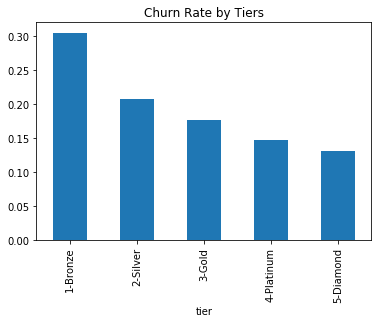

In [16]:
temp_df = churn_df.groupby(['tier'])['churn_year_plus1_ind'].mean()
temp_df.plot.bar(title="Churn Rate by Tiers")

### Create histogram to explore distribution of variables in churn data

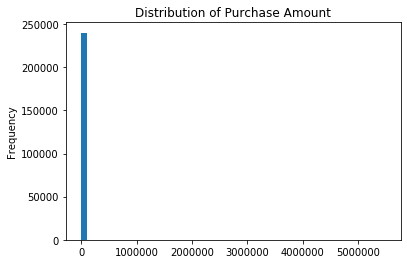

In [17]:
churn_df['purch_amt_life'].plot.hist(title="Distribution of Purchase Amount",bins=50)

### Create histogram to explore distribution of variables in margin data:


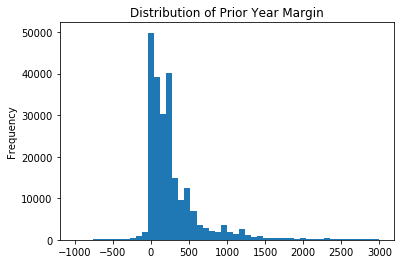

In [18]:
temp_df = margin_df.query('-1000<margin_Y_neg_1<3000')
temp_df['margin_Y_neg_1'].plot.hist(title="Distribution of Prior Year Margin",bins=50)

### Feature Engineering on Churn data

In [19]:
""" when avg interval = -1 replace with 36 months """
churn_df['purch_avg_interval'].replace([-1], 36, inplace=True)

""" when avg purchase = -1 replace with 0 """
churn_df['purch_avg_36mo'].replace([-1], 0, inplace=True)

churn_df['log_order_cnt_36mo']=np.log10(churn_df['order_cnt_36mo']+1)
churn_df['log_purch_amt_36mo']=np.log10(churn_df['purch_amt_36mo']+1)
churn_df['log_purch_amt_life']=np.log10(churn_df['purch_amt_life']+1)
churn_df['log_purch_avg_36mo']=np.log10(churn_df['purch_avg_36mo']+1)
churn_df['log_purch_cnt_life']=np.log10(churn_df['purch_cnt_life']+1)
churn_df['log_purch_cnt_tt_36mo']=np.log10(churn_df['purch_cnt_tt_36mo']+1)
churn_df['log_resp_cnt_36mo']=np.log10(churn_df['resp_cnt_36mo']+1)

churn_df['perc_purch_cc_36mo']=np.where(churn_df['purch_cnt_tt_36mo']==0,0,churn_df['purch_cnt_cc_36mo']/churn_df['purch_cnt_tt_36mo'])
churn_df['perc_purch_ck_36mo']=np.where(churn_df['purch_cnt_tt_36mo']==0,0,churn_df['purch_cnt_ck_36mo']/churn_df['purch_cnt_tt_36mo'])
churn_df['perc_purch_et_36mo']=np.where(churn_df['purch_cnt_tt_36mo']==0,0,churn_df['purch_cnt_et_36mo']/churn_df['purch_cnt_tt_36mo'])

churn_df = churn_df.drop(['order_cnt_36mo','purch_amt_36mo','purch_amt_life','purch_avg_36mo','purch_cnt_life',
                          'purch_cnt_tt_36mo','resp_cnt_36mo',
                          'purch_cnt_cc_36mo','purch_cnt_ck_36mo','purch_cnt_et_36mo'],axis=1)

print(" summary stats on churn data ") 
print(churn_df.describe(include='all').transpose())

 summary stats on churn data 
                            count  unique         top    freq   mean   std  min   25%   50%      75%      max
ST                         240368      61          TX   21633    NaN   NaN  NaN   NaN   NaN      NaN      NaN
Zip                        240368   26124     missing     894    NaN   NaN  NaN   NaN   NaN      NaN      NaN
DMA                        240368     216         803    9721    NaN   NaN  NaN   NaN   NaN      NaN      NaN
Area_Cd                    240368     384     missing   13090    NaN   NaN  NaN   NaN   NaN      NaN      NaN
emailable                 2.4e+05     NaN         NaN     NaN   0.51   0.5    0     0     1        1        1
solicit_ph_ind            2.4e+05     NaN         NaN     NaN   0.89  0.31    0     1     1        1        1
solicit_email_ind         2.4e+05     NaN         NaN     NaN   0.96  0.19    0     1     1        1        1
fixd_incm_flg             2.4e+05     NaN         NaN     NaN  0.092  0.29    0     0     

### Histogram plot on new log variable un churn data

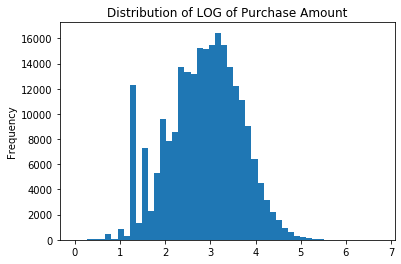

In [20]:
churn_df['log_purch_amt_life'].plot.hist(title="Distribution of LOG of Purchase Amount",bins=50)

### Feature Engineering on Margin data while keeping Orginal variables. Using Log transformation to control for huge negative values in margin. Also calculating the 3 year margin average

In [21]:
margin_df['margin_3yr_avg']=(margin_df['margin_Y_neg_1']+margin_df['margin_Y_neg_2']+margin_df['margin_Y_neg_3'])/3
margin_df['log_margin_Y_neg_1']=np.log10(margin_df['margin_Y_neg_1']+50000)
margin_df['log_margin_Y_neg_2']=np.log10(margin_df['margin_Y_neg_2']+50000)
margin_df['log_margin_Y_neg_3']=np.log10(margin_df['margin_Y_neg_3']+50000)
margin_df['log_margin_3yr_avg']=np.log10(margin_df['margin_3yr_avg']+50000)
margin_df['log_margin_Y_pos_1']=np.log10(margin_df['margin_Y_pos_1']+50000)

### Histogram on transformed target for Margin Data

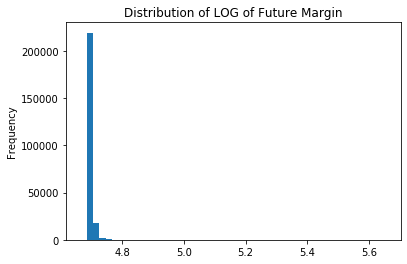

In [22]:
margin_df['log_margin_Y_pos_1'].plot.hist(title="Distribution of LOG of Future Margin",bins=50)

### Scatter Plot on Future Margin vs Prior Margins (Log values)

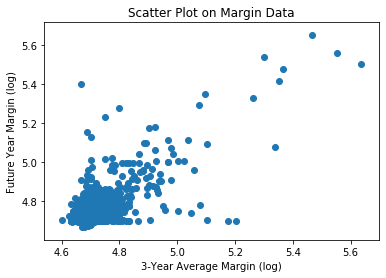

In [23]:
plt.scatter(margin_df['log_margin_3yr_avg'], margin_df['log_margin_Y_pos_1'])
plt.xlabel("3-Year Average Margin (log)")
plt.ylabel("Future Year Margin (log)")
plt.title("Scatter Plot on Margin Data")
print(" ") 
plt.show()

### Perforning Analysis on Demographics Data

In [24]:
demog_df.head()

,demog_assets,demog_LOR,demog_ownrent,demog_age,demog_span,demog_inc_fine,demog_inc_crs,demog_generations,demog_homevalue,demog_adults,acct_ID
0,IPA <= 25000,4th Year,Definite Renter,35-44 years old,1,$ 20000 - $ 29999,$ 15000 - $ 29999,2.0,NaN,2.0,I148760611
1,IPA <= 25000,13 - 18 Months,NaN,35-44 years old,0,NaN,NaN,1.0,NaN,1.0,I151076142
2,IPA <= 25000,11th Year,NaN,55-64 years old,0,Less than $15000,Less than $15000,1.0,NaN,1.0,I27001315
3,250000 < IPA <= 500000,3rd Year,Definite Owner (any type dwelling unit),55-64 years old,0,$ 50000 - $ 74999,$ 50000 - $ 74999,1.0,$150000 - $199999,1.0,I150064127
4,250000 < IPA <= 500000,9th Year,Definite Owner (any type dwelling unit),45-54 years old,0,$ 100000 - $124999,$ 100000 - $149999,2.0,$350000 - $399999,3.0,I152631565


In [25]:
#Looking at the variable summary statistics
print("Summary Stats for Demographic variables")
demog_df.describe(include='all').T

Summary Stats for Demographic variables


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
demog_assets,238937,10,IPA <= 25000,115016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_LOR,228229,22,20 or more Years,59828,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_ownrent,168544,4,Definite Owner (any type dwelling unit),153895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_age,228229,7,55-64 years old,54129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_span,2.4e+05,NaN,NaN,NaN,0.014,0.12,0,0,0,0,1
demog_inc_fine,221488,13,$ 50000 - $ 74999,40683,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_inc_crs,221488,9,$ 15000 - $ 29999,59259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_generations,2.3e+05,NaN,NaN,NaN,1.3,0.57,1,1,1,2,4
demog_homevalue,127547,17,Less than $50000,27388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_adults,2.2e+05,NaN,NaN,NaN,1.8,0.84,1,1,2,2,5


#### Correcting the own/rent variable based on the levels

In [26]:
print(" ") 
print("count of accounts by ownrent variable")
print(" ") 
print(demog_df.groupby('demog_ownrent')['acct_ID'].count())



 
count of accounts by ownrent variable
 
demog_ownrent
Definite Owner (any type dwelling unit)    153895
Definite Renter                              5388
Probable Owner (any type dwelling unit)      4016
Probable Renter                              5245
Name: acct_ID, dtype: int64


In [27]:
# recoding the long values for ownrent variable

demog_df['demog_ownrent']=np.where(demog_df['demog_ownrent']=='Definite Owner (any type dwelling unit)','Definite Owner',
                        np.where(demog_df['demog_ownrent']=='Probable Owner (any type dwelling unit)','Probable Owner',
                                 demog_df['demog_ownrent']))


In [28]:
print(demog_df.groupby('demog_ownrent')['acct_ID'].count())

demog_ownrent
Definite Owner     153895
Definite Renter      5388
Probable Owner       4016
Probable Renter      5245
Name: acct_ID, dtype: int64


In [29]:
# Counts of records by Length-of-Residence metric

print(" ") 
print("count of accounts by LOR variable")
print(" ") 
print(demog_df.groupby('demog_LOR')['acct_ID'].count())

 
count of accounts by LOR variable
 
demog_LOR
00 - 06 Months       4920
07 - 12 Months       3600
10th Year            8362
11th Year            7829
12th Year            7336
13 - 18 Months       6796
13th Year            6305
14th Year            5869
15th Year            5954
16th Year            5429
17th Year            5418
18th Year            5261
19 - 24 Months       7283
19th Year            4389
20 or more Years    59828
3rd Year            15922
4th Year            13748
5th Year            12410
6th Year            12486
7th Year            10485
8th Year            10008
9th Year             8591
Name: acct_ID, dtype: int64


In [30]:
# recoding the LOR variable to collapse levels

demog_df['demog_LOR']=np.where(demog_df['demog_LOR']=='00 - 06 Months','00 to 05 years',
                         np.where(demog_df['demog_LOR']=='07 - 12 Months','00 to 05 years',
                         np.where(demog_df['demog_LOR']=='13 - 18 Months','00 to 05 years', 
                         np.where(demog_df['demog_LOR']=='19 - 24 Months','00 to 05 years',
                         np.where(demog_df['demog_LOR']=='3rd Year',      '00 to 05 years',
                         np.where(demog_df['demog_LOR']=='4th Year',      '00 to 05 years', 
                         np.where(demog_df['demog_LOR']=='5th Year',      '00 to 05 years',  
                         np.where(demog_df['demog_LOR']=='6th Year',      '06 to 10 years',   
                         np.where(demog_df['demog_LOR']=='7th Year',      '06 to 10 years', 
                         np.where(demog_df['demog_LOR']=='8th Year',      '06 to 10 years',   
                         np.where(demog_df['demog_LOR']=='9th Year',      '06 to 10 years',
                         np.where(demog_df['demog_LOR']=='10th Year',     '06 to 10 years',     
                         np.where(demog_df['demog_LOR']=='11th Year',     '11 to 19 years',     
                         np.where(demog_df['demog_LOR']=='12th Year',     '11 to 19 years',  
                         np.where(demog_df['demog_LOR']=='13th Year',     '11 to 19 years',     
                         np.where(demog_df['demog_LOR']=='14th Year',     '11 to 19 years',  
                         np.where(demog_df['demog_LOR']=='15th Year',     '11 to 19 years',     
                         np.where(demog_df['demog_LOR']=='16th Year',     '11 to 19 years',  
                         np.where(demog_df['demog_LOR']=='17th Year',     '11 to 19 years',     
                         np.where(demog_df['demog_LOR']=='18th Year',     '11 to 19 years',
                         np.where(demog_df['demog_LOR']=='19th Year',     '11 to 19 years',     
                         np.where(demog_df['demog_LOR']=='20 or more Years',     '20+ years',                                    
                                 demog_df['demog_LOR']))))))))))))))))))))))

print(" ") 
print("count of account IDs by new LOR levels")
print(" ") 
print(demog_df.groupby('demog_LOR')['acct_ID'].count())


 
count of account IDs by new LOR levels
 
demog_LOR
00 to 05 years    64679
06 to 10 years    49932
11 to 19 years    53790
20+ years         59828
Name: acct_ID, dtype: int64


#### creating some numeric versions of some of the categorical demographics

In [31]:

demog_df['demog_assets_num']=np.nan
demog_df['demog_assets_num']=np.where(demog_df['demog_assets']== 'IPA <= 25000',        12500, 
                      np.where(demog_df['demog_assets']== '25000 < IPA <= 50000',       37500,
                      np.where(demog_df['demog_assets']== '50000 < IPA <= 75000',       62500,
                      np.where(demog_df['demog_assets']== '75000 < IPA <= 100000',      87500,
                      np.where(demog_df['demog_assets']== '100000 < IPA <= 250000',    175000,
                      np.where(demog_df['demog_assets']== '250000 < IPA <= 500000',    375000,
                      np.where(demog_df['demog_assets']== '500000 < IPA <= 750000',    650000,
                      np.where(demog_df['demog_assets']== '750000 < IPA <= 1000000',   875000,
                      np.where(demog_df['demog_assets']== '1000000 < IPA <= 2000000', 1500000,
                      np.where(demog_df['demog_assets']== '2000000 < IPA', 2500000, demog_df['demog_assets_num']))))))))))

demog_df['demog_inc_num']=np.nan
demog_df['demog_inc_num']=np.where(demog_df['demog_inc_fine']== 'Less than $15000',10000, 
                      np.where(demog_df['demog_inc_fine']== '$  15000 - $  19999', 17500,
                      np.where(demog_df['demog_inc_fine']== '$  20000 - $  29999', 25000,
                      np.where(demog_df['demog_inc_fine']== '$  30000 - $  39999', 35000,
                      np.where(demog_df['demog_inc_fine']== '$  40000 - $  49999', 45000,
                      np.where(demog_df['demog_inc_fine']== '$  50000 - $  74999', 62500,
                      np.where(demog_df['demog_inc_fine']== '$  75000 - $  99999', 87500,
                      np.where(demog_df['demog_inc_fine']== '$ 100000 - $124999', 112500,
                      np.where(demog_df['demog_inc_fine']== '$ 125000 - $149999', 137500,
                      np.where(demog_df['demog_inc_fine']== '$ 150000 - $174999', 162500,
                      np.where(demog_df['demog_inc_fine']== '$ 175000 - $199999', 187500,
                      np.where(demog_df['demog_inc_fine']== '$ 200000 - $249999', 225000,
                      np.where(demog_df['demog_inc_fine']== '$ 250000 or more',   300000,
                               demog_df['demog_inc_num'])))))))))))))


In [32]:
# and dropping the original non-numeric versions from the data:

demog_df = demog_df.drop(['demog_inc_fine','demog_assets'],axis=1)

In [33]:
demog_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
demog_LOR,228229,4,00 to 05 years,64679,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_ownrent,168544,4,Definite Owner,153895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_age,228229,7,55-64 years old,54129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_span,2.4e+05,NaN,NaN,NaN,0.014,0.12,0,0,0,0,1
demog_inc_crs,221488,9,$ 15000 - $ 29999,59259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_generations,2.3e+05,NaN,NaN,NaN,1.3,0.57,1,1,1,2,4
demog_homevalue,127547,17,Less than $50000,27388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_adults,2.2e+05,NaN,NaN,NaN,1.8,0.84,1,1,2,2,5
acct_ID,240368,239356,I151801830,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demog_assets_num,2.4e+05,NaN,NaN,NaN,1.5e+05,3.4e+05,1.2e+04,1.2e+04,3.8e+04,1.8e+05,2.5e+06


In [34]:
demog_df.dtypes

demog_LOR             object
demog_ownrent         object
demog_age             object
demog_span             int64
demog_inc_crs         object
demog_generations    float64
demog_homevalue       object
demog_adults         float64
acct_ID               object
demog_assets_num     float64
demog_inc_num        float64
dtype: object

### Eliminating Duplicate Records in all 3 datasets

In [35]:
churn_df.drop_duplicates(subset=['acct_ID'], keep='first', inplace=True)
margin_df.drop_duplicates(subset=['acct_ID'], keep='first', inplace=True)
demog_df.drop_duplicates(subset=['acct_ID'], keep='first', inplace=True)

churn_df.shape, margin_df.shape, demog_df.shape

((239356, 31), (239356, 11), (239356, 11))

In [36]:
#Joining the churn and margin data
inter_df = pd.merge(churn_df, margin_df, on='acct_ID', how='inner')
inter_df.shape

(239356, 41)

In [37]:
#final dataset combined
combined_df=pd.merge(inter_df,demog_df,on='acct_ID',how='inner')
combined_df.shape

(239356, 51)

### Create dummy variables for certain categorical variables.


In [39]:
""" WARNING: this commented-out approach would create dummy indicators for all """
"""    categorical variables, including those with very high cardinality, such as zip codes """
"""    and also would drop the original categorical variables and only keep the dummy indicators """

""" combined_df = pd.get_dummies(combined_df) """

""" this approach hand-picks only certain variables for which to create dummy indicators """
""" and keeps the original variables too """

for column in ['ST', 'tier', 'tier_prev','demog_LOR','demog_ownrent','demog_age','demog_inc_crs']:
    dummies = pd.get_dummies(combined_df[column],prefix=column)
    combined_df[dummies.columns] = dummies

print(" ") 
print("Columns in new data")
print(" ") 
print(combined_df.dtypes)

 
Columns in new data
 
ST                                    object
Zip                                   object
DMA                                   object
Area_Cd                               object
emailable                              int64
solicit_ph_ind                         int64
solicit_email_ind                      int64
fixd_incm_flg                          int64
scheduled_purchase_flg                 int64
months_since_last_trans                int64
months_since_first_trans               int64
purch_avg_interval                   float64
mail_cnt_36mo                          int64
call_in_mo_36mo                        int64
call_out_mo_36mo                       int64
tier                                  object
tier_prev                             object
acct_ID                               object
activation_date                       object
event_date                            object
churn_year_plus1_ind                   int64
log_order_cnt_36mo             

## Start of Part 2

In [40]:
#performing some basic exploratory analysis on the combined data

""" Analyzing average values of numeric variables, by the levels of the binary target variable """
print(" ") 
print("Averages by churn ind")
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['log_purch_amt_life'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['scheduled_purchase_flg'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['months_since_last_trans'].mean())

 
Averages by churn ind
 
churn_year_plus1_ind
0    3.00
1    2.48
Name: log_purch_amt_life, dtype: float64
 
 
churn_year_plus1_ind
0    3.52e-01
1    4.28e-03
Name: scheduled_purchase_flg, dtype: float64
 
 
churn_year_plus1_ind
0    1.76
1    6.15
Name: months_since_last_trans, dtype: float64


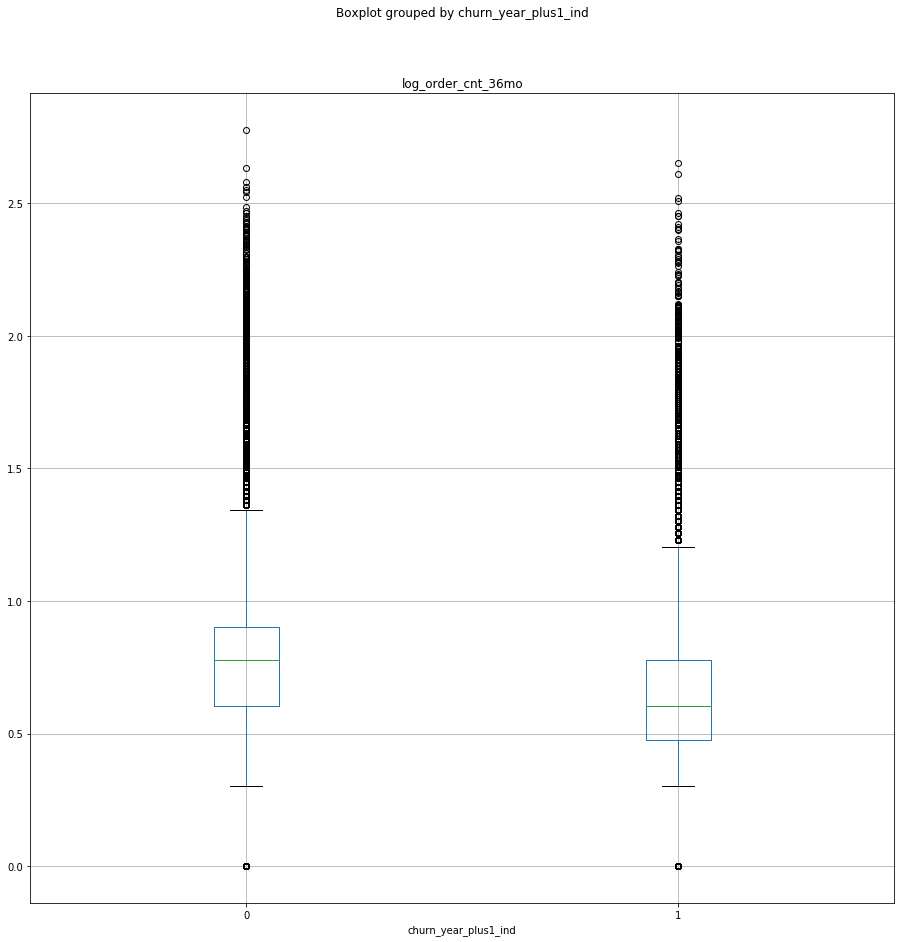

In [41]:
""" A boxplot to investigate the distribution of numeric variables by the levels of the target """

combined_df.boxplot(column='log_order_cnt_36mo', by='churn_year_plus1_ind',figsize=(15,15))

### Dropping variables we don't want included in modeling, and creating new version of data for modeling:

In [69]:
""" Any categorical variable for which we did not create dummy indicators        """
"""    and other variables we don't want in the model, or which don't make sense """
"""    to be included in model training, we are dropping here:                   """

""" Note:  we also want to drop acct_ID, but we are going to do that after partioning """
"""        because we need acct_ID for partioned sets to for reference later          """

x_train_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date','demog_LOR',
                            'ST','tier','tier_prev','demog_homevalue','demog_ownrent','demog_age',
                               'demog_inc_crs','demog_generations','demog_adults','demog_assets_num','demog_inc_num']
                              ,axis=1)


In [70]:
x_train_df.shape

(239356, 130)

### Partitioning data into Training and Test sets, creating X vs Y sets, and creating dataframes with just account IDs to be used to rejoin data later:

In [71]:
x_train_df, x_test_df = train_test_split(x_train_df, test_size = 0.30, random_state= 42)

""" will need the acct_IDs to rejoin data later, so pulling out now before dropping from actual model training data """

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]

""" the target (or dependent) variable is stored in it's own dataframe """

y_train_df = x_train_df[['churn_year_plus1_ind']]
y_test_df  = x_test_df[['churn_year_plus1_ind']]

""" and we want to drop acct_ID and the target variable from the dataframe of independent variables """
""" PLUS we want to drop the target (future timeframe) variables for margin modeling                """

x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)


In [72]:
print("Number of records in X training:",len(x_train_df))
print("Number of records in Y training:",len(y_train_df))
print("Number of records in X testing:",len(x_test_df))
print("Number of records in Y testing:",len(x_test_df))
x_train_df.shape

Number of records in X training: 167549
Number of records in Y training: 167549
Number of records in X testing: 71807
Number of records in Y testing: 71807


(167549, 126)

In [73]:
x_train_df.dtypes

emailable                              int64
solicit_ph_ind                         int64
solicit_email_ind                      int64
fixd_incm_flg                          int64
scheduled_purchase_flg                 int64
months_since_last_trans                int64
months_since_first_trans               int64
purch_avg_interval                   float64
mail_cnt_36mo                          int64
call_in_mo_36mo                        int64
call_out_mo_36mo                       int64
log_order_cnt_36mo                   float64
log_purch_amt_36mo                   float64
log_purch_amt_life                   float64
log_purch_avg_36mo                   float64
log_purch_cnt_life                   float64
log_purch_cnt_tt_36mo                float64
log_resp_cnt_36mo                    float64
perc_purch_cc_36mo                   float64
perc_purch_ck_36mo                   float64
perc_purch_et_36mo                   float64
margin_Y_neg_1                       float64
margin_Y_n

### Main objective now is to model the churn indicator to predict if a customer will churn or not.


### Using Logistic Regression as a variable selection technique.
#Need to change the C parameter and rerun to get a resonable number of selected variables

In [66]:
y_train_array

array([0, 0, 0, ..., 1, 0, 0])

In [79]:
""" models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero """
""" SelectFromModel can be used to to select effects with non-zero coefficients """
""" the parameter C controls the sparsity: the smaller C the fewer features selected """

""" using the ravel simply to avoid warning in log """
y_train_array=np.ravel(y_train_df)

""" start with C = 1.0, then try 0.1, then 0.01 """
model1 = linear_model.LogisticRegression(C = 0.01, solver='liblinear', penalty='l1', tol=0.01)
model1_fit = model1.fit(x_train_df, y_train_array)
model1_selects = SelectFromModel(model1_fit, prefit=True)
"""x_train_selected_df = model1_selects.transform(x_train_df)"""

""" in lieu of commented-out transform method above, can use this method to explicitly define columns to keep """
x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]

coefficients = pd.DataFrame(model1_fit.coef_)
coefficients = np.transpose(coefficients[coefficients.columns[model1_selects.get_support()]])
coefficients = coefficients.reset_index(drop=True)

coefficients_match = pd.concat([pd.DataFrame(x_train_selected_df.columns),coefficients], axis = 1)

coefficients.shape 

(41, 1)

In [80]:
print(" ") 
print("Coefficients for selected variables")
coefficients_match

 
Coefficients for selected variables


,0,0
0,emailable,-1.38e-01
1,solicit_ph_ind,-2.16e-01
2,solicit_email_ind,-1.38e-01
3,scheduled_purchase_flg,-3.84e+00
4,months_since_last_trans,4.06e-01
5,months_since_first_trans,-3.06e-03
6,purch_avg_interval,1.61e-03
7,mail_cnt_36mo,-7.90e-03
8,call_in_mo_36mo,-3.71e-04
9,call_out_mo_36mo,-1.72e-02


In [81]:
x_train_selected_df.shape

(167549, 41)

### Looking for multi-collineaity in the data

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
        else:
            dropped=False
    print('Remaining variables:')
    print(X.columns[variables])        
        
    return X.iloc[:, variables]

x_train_selected_df=calculate_vif_(x_train_selected_df, 10.0)
        
x_train_selected_df.shape

dropping 'log_margin_3yr_avg' at index: 24
dropping 'log_margin_Y_neg_2' at index: 22
dropping 'log_margin_Y_neg_1' at index: 21
dropping 'log_purch_amt_36mo' at index: 11
dropping 'log_margin_Y_neg_3' at index: 20
dropping 'log_purch_amt_life' at index: 11
dropping 'log_purch_cnt_life' at index: 12
dropping 'perc_purch_ck_36mo' at index: 15
dropping 'log_purch_cnt_tt_36mo' at index: 12
dropping 'solicit_email_ind' at index: 2
dropping 'log_purch_avg_36mo' at index: 10
dropping 'tier_prev_xxx' at index: 17
dropping 'log_order_cnt_36mo' at index: 9
Remaining variables:
Index(['emailable', 'solicit_ph_ind', 'scheduled_purchase_flg', 'months_since_last_trans', 'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo', 'call_in_mo_36mo', 'call_out_mo_36mo', 'log_resp_cnt_36mo', 'perc_purch_cc_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_1', 'tier_1-Bronze', 'tier_2-Silver', 'tier_prev_1-Bronze', 'demog_LOR_00 to 05 years', 'demog_LOR_11 to 19 years', 'demog_LOR_20+ years', 'demog_own

(167549, 28)

In [87]:
x_train_selected_df.shape,x_test_selected_df.shape

((167549, 28), (71807, 28))

In [83]:
x_train_selected_df.shape[1]

41

### Reducing Testing set to match the training data columns


In [86]:
""" reducing the test set to have the same columns as the training set """

x_test_selected_df=x_test_selected_df[x_train_selected_df.columns]
print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['emailable', 'solicit_ph_ind', 'scheduled_purchase_flg', 'months_since_last_trans', 'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo', 'call_in_mo_36mo', 'call_out_mo_36mo', 'log_resp_cnt_36mo', 'perc_purch_cc_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_1', 'tier_1-Bronze', 'tier_2-Silver', 'tier_prev_1-Bronze', 'demog_LOR_00 to 05 years', 'demog_LOR_11 to 19 years', 'demog_LOR_20+ years', 'demog_ownrent_Definite Owner', 'demog_age_25-34 years old', 'demog_age_55-64 years old', 'demog_age_65-74 years old', 'demog_age_75+ years old', 'demog_inc_crs_$  15000 - $  29999', 'demog_inc_crs_$  50000 - $  74999', 'demog_inc_crs_$  75000 - $  99999', 'demog_inc_crs_$ 100000 - $149999'], dtype='object')


(71807, 28)

In [88]:
#Looking at Logistic Model with a easier approach

""" for the statsmodels, need to add a constant to fit intercept """

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')

""" modeling with selected variables from steps above """

model = sm.Logit(y_train_df, x_train_selected_df)
result = model.fit(maxiter=100)

print(" ") 
print("Logistic model with selected variables")
print(" ") 
print(result.summary2())
print('AIC: ', result.aic)
print('BIC: ', result.bic)

Optimization terminated successfully.
         Current function value: 0.317984
         Iterations 10
 
Logistic model with selected variables
 
                                  Results: Logit
Model:                  Logit                    Pseudo R-squared:     0.448      
Dependent Variable:     churn_year_plus1_ind     AIC:                  106613.7175
Date:                   2020-10-09 17:26         BIC:                  106904.5594
No. Observations:       167549                   Log-Likelihood:       -53278.    
Df Model:               28                       LL-Null:              -96520.    
Df Residuals:           167520                   LLR p-value:          0.0000     
Converged:              1.0000                   Scale:                1.0000     
No. Iterations:         10.0000                                                   
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z   

### Using the statsmodels Logit model to score the data and evaluate goodness-of-fit:

AROC train:  0.9190694414381924
AROC test:  0.9189348492253802


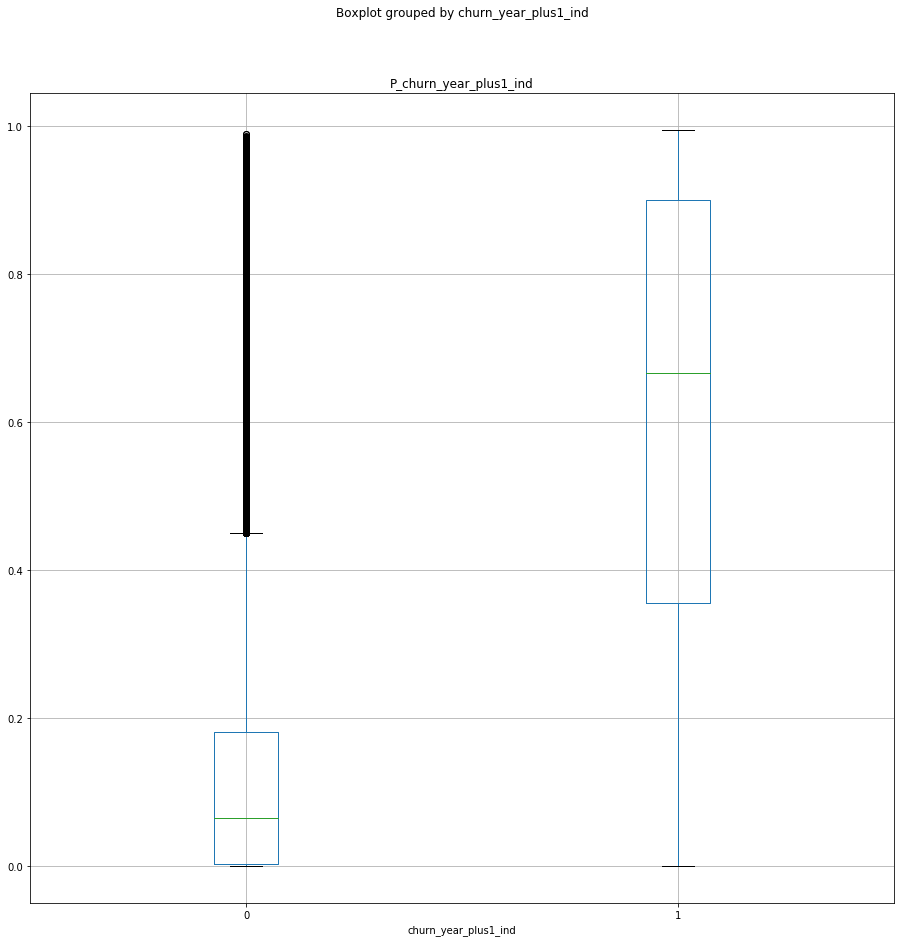

In [89]:
""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

""" joining predicted and actuals """
""" NOTE:  for reference, for now...to be used more later to create complete """
"""     dataframe with all obs and inputs and outputs """
train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

# print(" ") 
# print("MSE train:", mean_squared_error(y_train_df, predict_train))
# print("MSE test:", mean_squared_error(y_test_df, predict_test))

# print(" ") 
# print("testing that the joining process works. if so, these MSE should match the ones above.")
# print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
# print("mean squared error testn:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))

pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

### Running a gradient Boosting Model

GB overall accuracy: 0.8792318297659003
AROC train:  0.9433595185633814
AROC test:  0.9382174835367089
 
MSE train: 0.08294141884770052
MSE test: 0.0866938537604314
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.08294141884769976
mean squared error test: 0.08669385376043037


Text(0, 0.5, 'AROC')

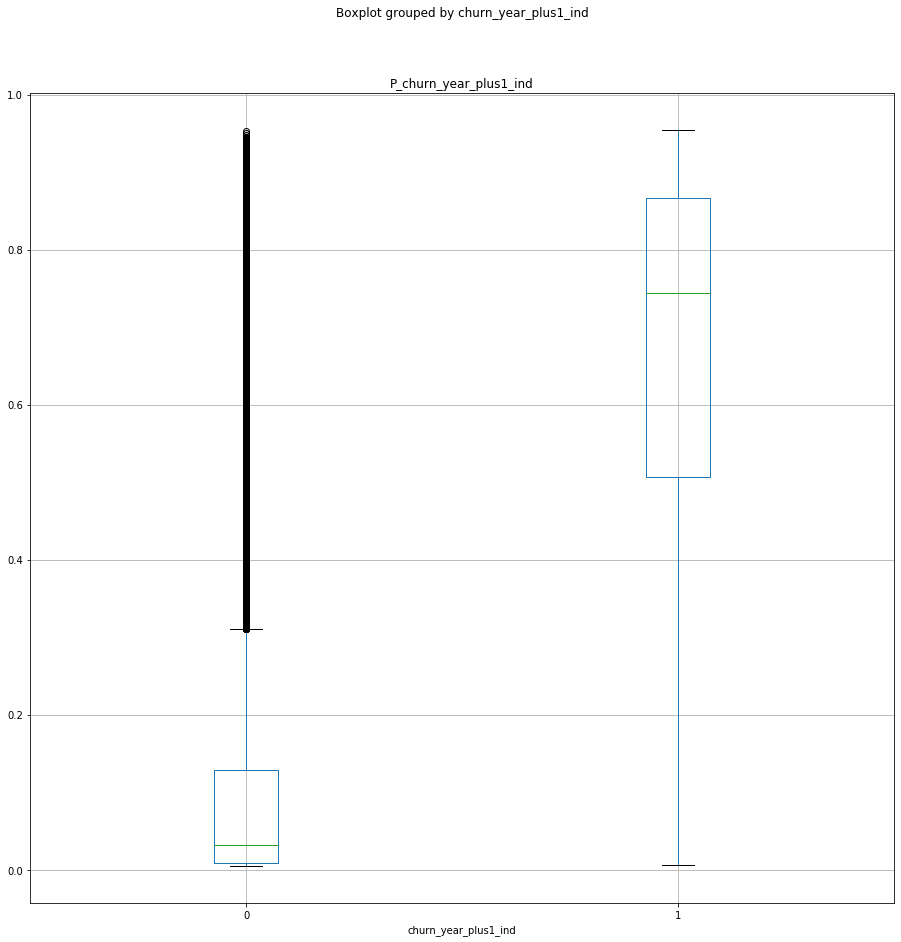

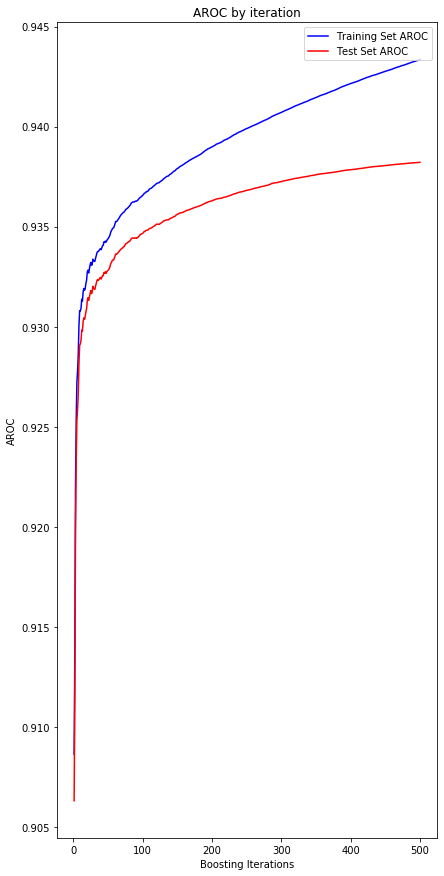

In [92]:
""" Gradient Boosting """

# setting some parameters
# n_estimators = number of iterations
# min_samples_split should be ~0.5-1% of record count?
# min_samples_leaf can be selected based on intuition. 
# max_depth = 8 should be chosen (5-8) based on the number of observations and predictors. 
# max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
# subsample = 0.8 : This is a commonly used used start value.
    
params = {'n_estimators': 500, 'learning_rate':0.01, 'min_samples_split':100, 'min_samples_leaf':10, 'max_depth':8, 'max_features':'sqrt','subsample':0.8,'random_state':10}

model2 = GradientBoostingClassifier(**params)

""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result = model2.fit(x_train_selected_df, y_train_array)

""" returns overall accuracy"""
accuracy = model2.score(x_test_selected_df, y_test_df)
print("GB overall accuracy:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model2.predict_proba(x_train_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(model2.predict_proba(x_test_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)


test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

# print(" ") 
# print("testing that the joining process works. if so, these MSE should match the ones above.")
# print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
# print("mean squared error test:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))


pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

""" plotting AROC with each iteration of the Gradient Boosting algorithm """

""" converting Y dataframes into arrays as needed for logic below """
y_traint_array = y_train_df.values
y_test_array = y_test_df.values

test_AROC  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_AROC = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model2.staged_predict_proba(x_test_selected_df)):
    test_AROC[i] = metrics.roc_auc_score(y_test_array, y_pred[:, 1])

for i, y_pred in enumerate(model2.staged_predict_proba(x_train_selected_df)):
    train_AROC[i] = metrics.roc_auc_score(y_train_array, y_pred[:, 1])

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('AROC by iteration')
plt.plot(np.arange(params['n_estimators']) + 1, train_AROC, 'b-',
         label='Training Set AROC')
plt.plot(np.arange(params['n_estimators']) + 1, test_AROC, 'r-',
         label='Test Set AROC')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('AROC')


### Feature importance for gradient boosting model

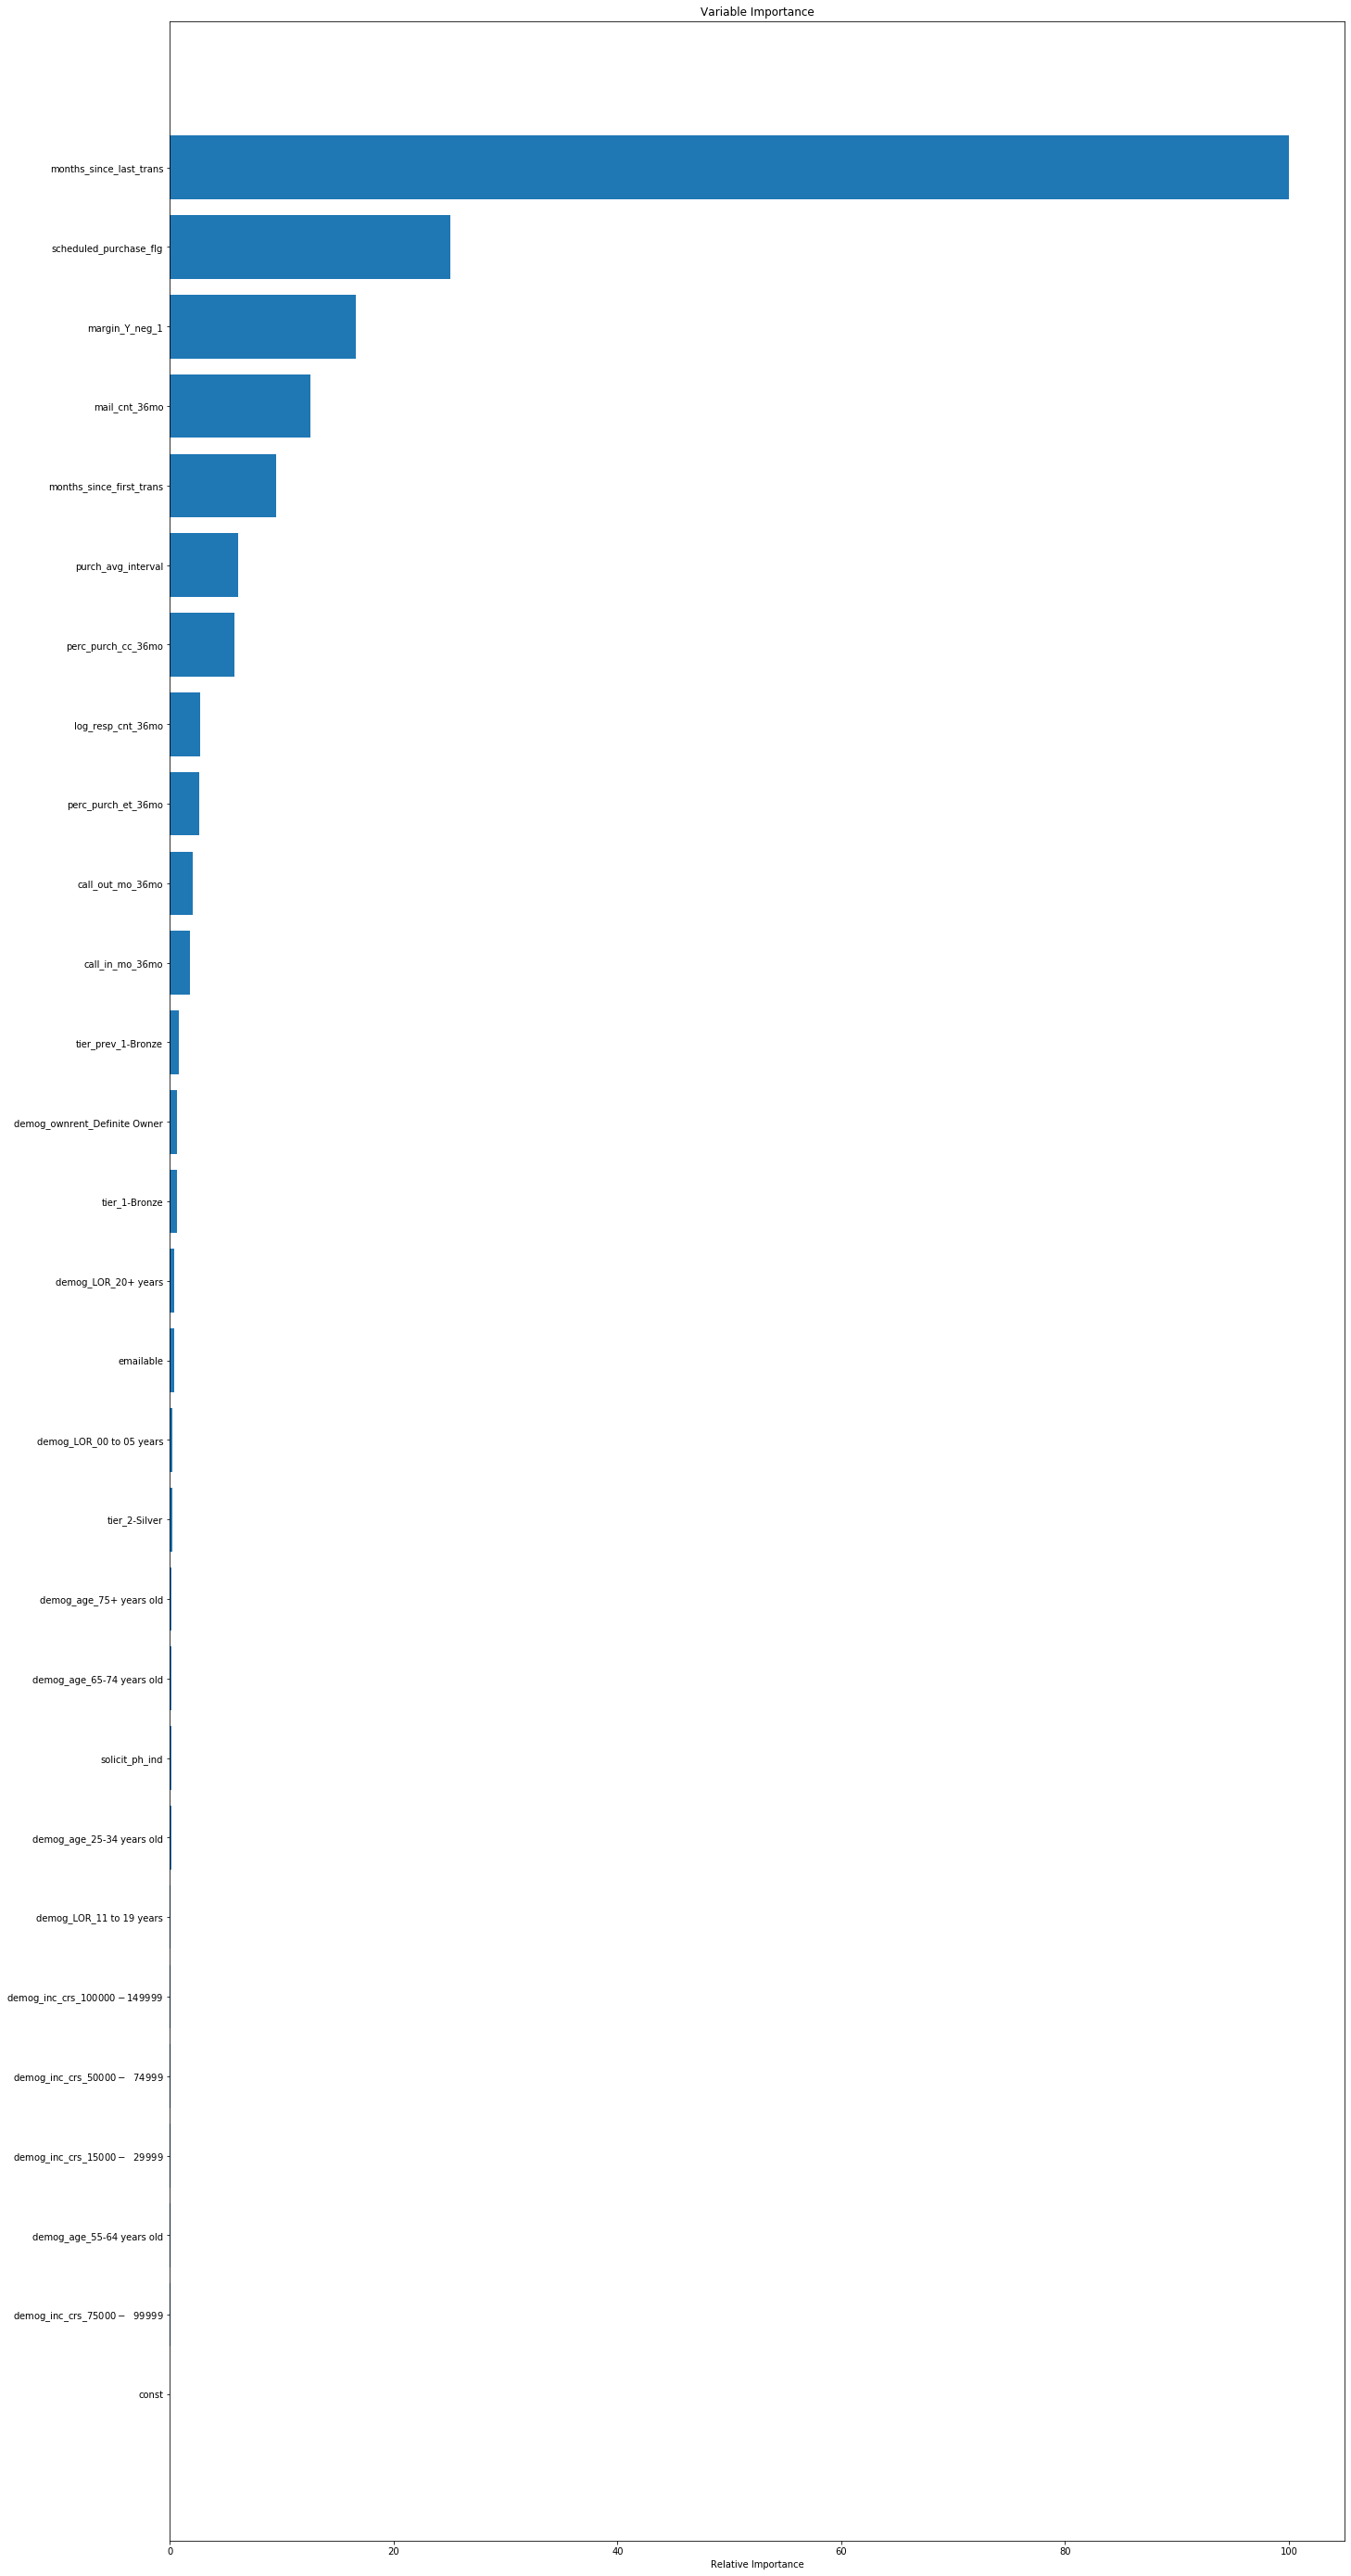

In [93]:
feature_importance = model2.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,50))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Appending the train and test sets, and keeping the acct_IDs and predicted churn probabilities

In [94]:
""" append together train and test predicted values, keeping only acct ID and predicted values """

pred_v_actual_train=pred_v_actual_train.append(pred_v_actual_test, ignore_index=True)

pred_v_actual_train = pred_v_actual_train.drop(['churn_year_plus1_ind'],axis=1)

""" and then save predicted values by acct ID to csv """

pred_v_actual_train.to_csv(r'churn_scores.csv',index=False)
pred_v_actual_train.shape

(239356, 2)

In [95]:
pred_v_actual_train.dtypes

P_churn_year_plus1_ind    float64
acct_ID                    object
dtype: object

### pred_v_actual has all the predicted probabilties for each account ID

### Start for Step 3

### margin Modeling

In [104]:
""" Any categorical variable for which we did not create dummy indicators        """
"""    and other variables we don't want in the model, or which don't make sense """
"""    to be included in model training, we are dropping here:                   """

""" Note:  we also want to drop acct_ID, but we are going to do that after partioning """
"""        because we need acct_ID for partioned sets to for reference later          """

x_train_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date','demog_LOR',
                            'ST','tier','tier_prev','demog_homevalue','demog_ownrent','demog_age',
                               'demog_inc_crs','demog_generations','demog_adults','demog_assets_num','demog_inc_num']
                              ,axis=1)


## This step was not performed for churn modeling.
## We are going to eliminate the records associated with the "churners".
## Because of our approach to calculating future value, we want to predict
##    the expect future margin *given* that the customer remains a customer.

In [105]:
""" first we keep the churners, to score them later """
x_churners_df = x_train_df.query('churn_year_plus1_ind==1')
""" then we strip our the churners from the data to be used for training and testing """
x_train_df = x_train_df.query('churn_year_plus1_ind==0')

x_train_df.shape, x_churners_df.shape
# we will score the churners later, but don't want them used for model training

((176267, 130), (63089, 130))

## Partitioning data into Training and Test sets, creating X vs Y sets, and creating dataframes with just account IDs to be used to rejoin data later.
## Note: for margin modeling, we have a different target variable than we did for churn.

In [107]:
x_train_df, x_test_df = train_test_split(x_train_df, test_size = 0.30)

""" will need the acct_IDs to rejoin data later, so pulling out now before dropping from actual model training data """

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]
churners_acct_IDs_df = x_churners_df[['acct_ID']]

""" the target (or dependent) variable is stored in it's own dataframe """

y_train_df = x_train_df[['log_margin_Y_pos_1']]
y_test_df  = x_test_df[['log_margin_Y_pos_1']]
y_churners_df  = x_churners_df[['log_margin_Y_pos_1']]

""" and we want to drop acct_ID and the target variable from the dataframe of independent variables """
""" PLUS we want to drop the target (future timeframe) variables for churn modeling                """

x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_churners_df = x_churners_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                                   ],axis=1)

x_train_df.shape

(123386, 126)

In [108]:
print("Number of records in X training:",len(x_train_df))
print("Number of records in Y training:",len(y_train_df))
print("Number of records in X testing:",len(x_test_df))
print("Number of records in Y testing:",len(x_test_df))
x_train_df.shape

Number of records in X training: 123386
Number of records in Y training: 123386
Number of records in X testing: 52881
Number of records in Y testing: 52881


(123386, 126)

## Using the SelectKBest and f_regression to select K parameters with highest f-values.
## We'll use this as a preliminary non-machine-learning approach.

In [109]:
""" using the ravel simply to avoid warning in log """
y_train_array=np.ravel(y_train_df)
y_test_array=np.ravel(y_test_df)

# this line can be used to suppress any warnings caused by missing values:
"""np.seterr(divide='ignore', invalid='ignore')"""

model1_selects = SelectKBest(f_regression, k=20).fit(x_train_df, y_train_array)

x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]
""" note: we are not reducing the columns in the held-out churners dataframe, because this is not our final model """

x_train_selected_df.shape

(123386, 20)

In [110]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
        else:
            dropped=False
    print('Remaining variables:')
    print(X.columns[variables])        
        
    return X.iloc[:, variables]

# to drop fewer variables, and allow more multicollinearity, increase the numeric threshold here.
#    10 is a good default.  try 15 or 20 to omit fewer variables
x_train_selected_df=calculate_vif_(x_train_selected_df, 10.0)
        
x_train_selected_df.shape

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'margin_Y_neg_1' at index: 6
dropping 'log_margin_3yr_avg' at index: 12
dropping 'log_margin_Y_neg_2' at index: 10
dropping 'log_margin_Y_neg_3' at index: 10
dropping 'log_purch_amt_life' at index: 3
dropping 'log_purch_amt_36mo' at index: 2
dropping 'log_margin_Y_neg_1' at index: 7
dropping 'margin_3yr_avg' at index: 6
dropping 'log_purch_cnt_life' at index: 3
Remaining variables:
Index(['mail_cnt_36mo', 'call_out_mo_36mo', 'log_purch_avg_36mo', 'margin_Y_neg_2', 'margin_Y_neg_3', 'tier_1-Bronze', 'tier_5-Diamond', 'tier_prev_3-Gold', 'tier_prev_4-Platinum', 'tier_prev_5-Diamond', 'tier_prev_xxx'], dtype='object')


(123386, 11)

### Reducing the testing data to match the training set

In [111]:
""" reducing the test set to have the same columns as the training set """
""" note: we are not reducing the columns in the held-out churners dataframe, because this is not our final model """

x_test_selected_df=x_test_selected_df[x_train_selected_df.columns]

print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['mail_cnt_36mo', 'call_out_mo_36mo', 'log_purch_avg_36mo', 'margin_Y_neg_2', 'margin_Y_neg_3', 'tier_1-Bronze', 'tier_5-Diamond', 'tier_prev_3-Gold', 'tier_prev_4-Platinum', 'tier_prev_5-Diamond', 'tier_prev_xxx'], dtype='object')


(52881, 11)

### Using the statsmodels package to see "friendlier" looking Regression output:


 
OLS model with selected variables
 
                            OLS Regression Results                            
Dep. Variable:     log_margin_Y_pos_1   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                 1.512e+04
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:11:40   Log-Likelihood:             4.2847e+05
No. Observations:              123386   AIC:                        -8.569e+05
Df Residuals:                  123374   BIC:                        -8.568e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

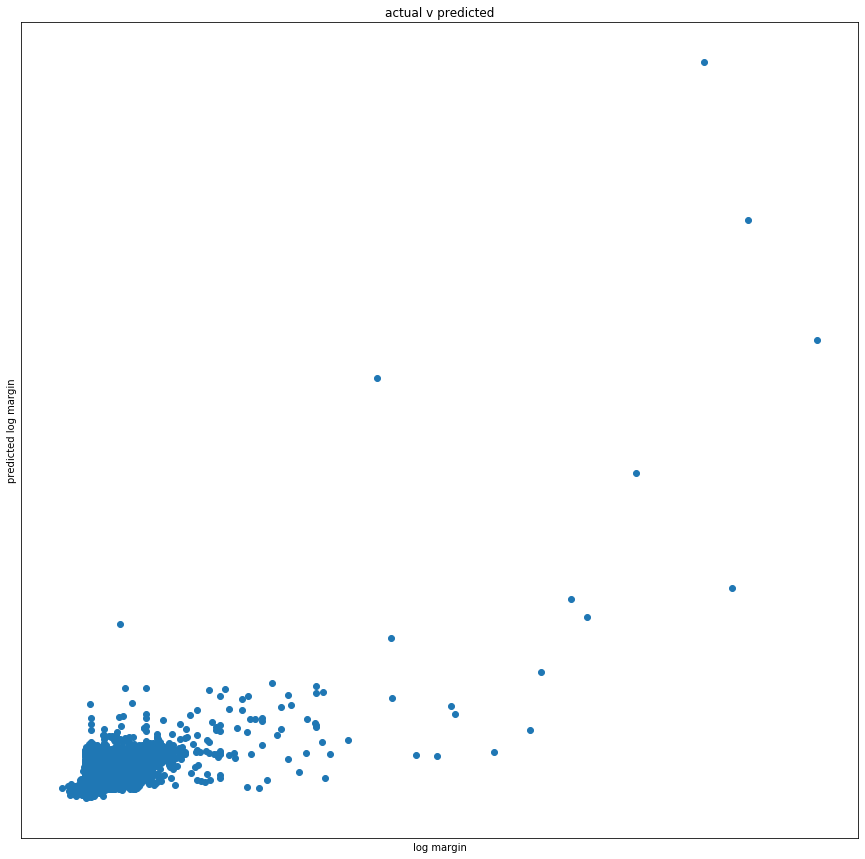

In [112]:
""" for the statsmodels, need to add a constant to fit intercept """
""" the add_constant function won't add a constant if there's already a variable with variance=0 """
"""     unless the has_constant option is added """

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')

""" warning:  the OLS here is case-sensitive """
model = sm.OLS(y_train_df, x_train_selected_df)
result = model.fit()
print(" ") 
print("OLS model with selected variables")
print(" ") 
print(result.summary())

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_log_margin_Y_pos_1"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_log_margin_Y_pos_1"])

print(" ") 
print("MSE train:", mean_squared_error(y_train_array, predict_train))
print("MSE test:", mean_squared_error(y_test_array, predict_test))

plt.figure(figsize=(15,15))
plt.scatter(y_train_array, predict_train)
plt.xlabel("log margin")
plt.ylabel("predicted log margin")
plt.title("actual v predicted")
plt.xticks([])
plt.yticks([])
print(" ") 
plt.show()

### Now to try a more advanced Machine Learning algorithm to see if we can get a better model.
##  Note: with steps below, significant variables are selected based on GB model, 
##        not using the more simplified f-test approach above.

GB overall accuracy, for model with all variables: 0.6395633312531124
 
MSE train, for model with all variables: 1.6167808313475394e-05
MSE test, for model with all variables: 3.906027186672679e-05


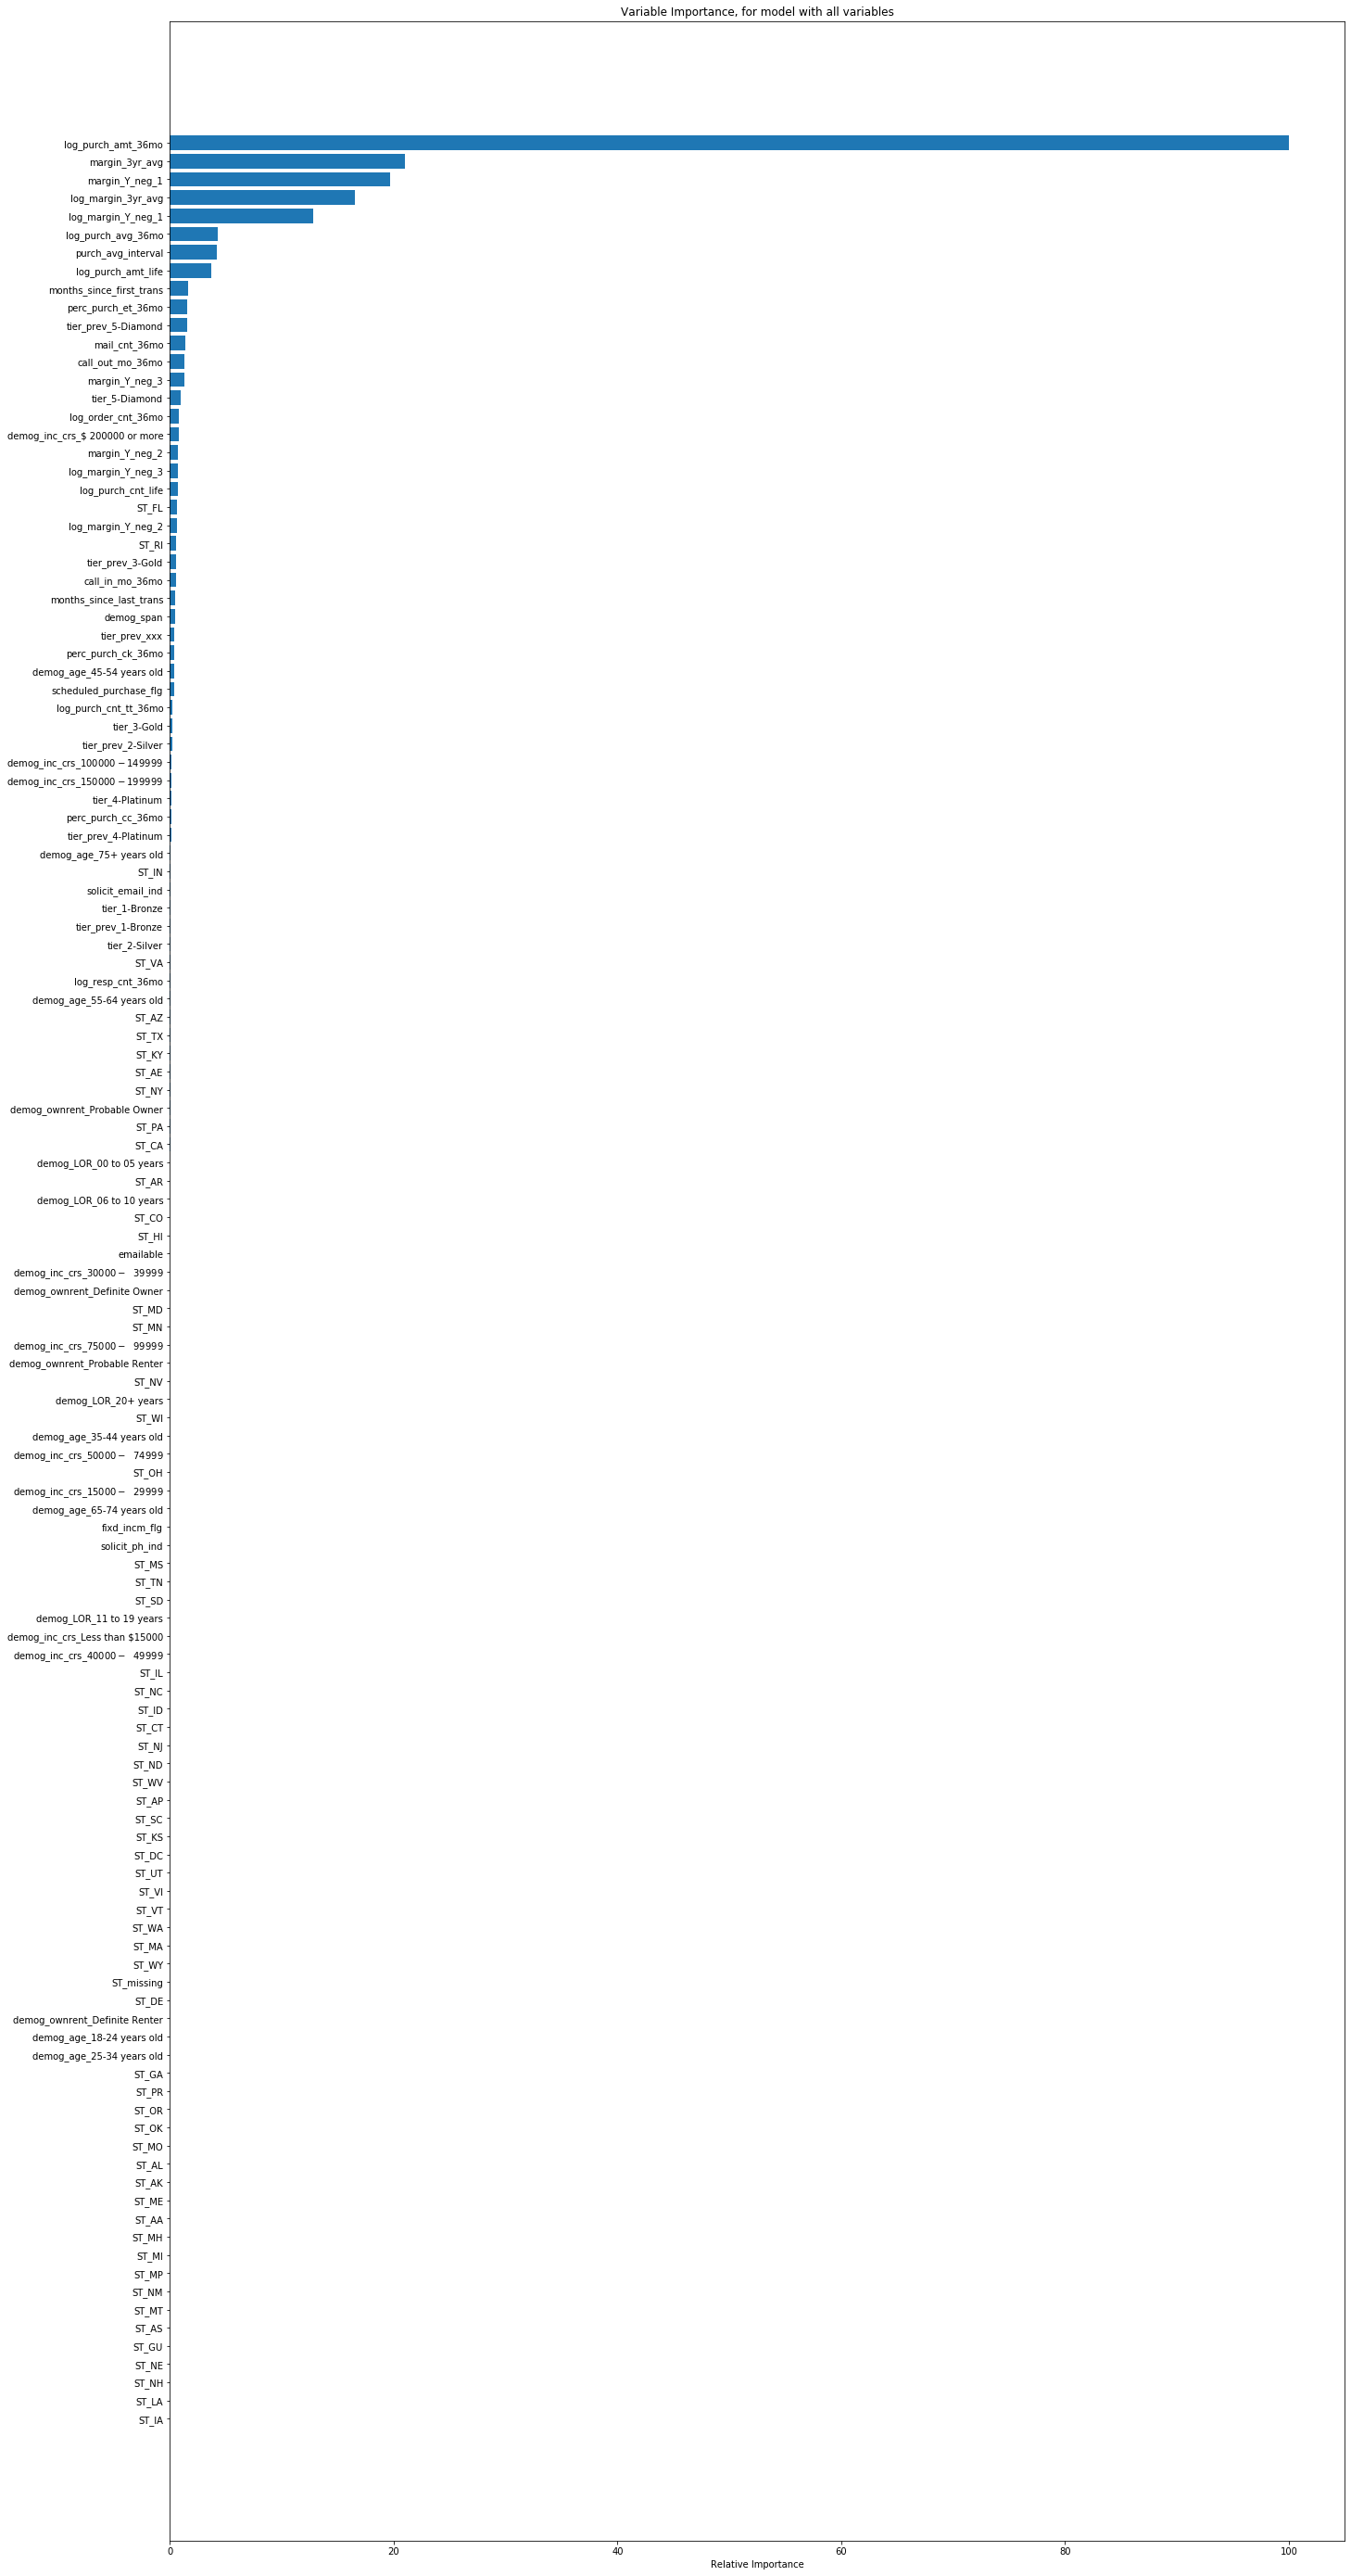

GB overall accuracy, for model with only selected features: 0.5601094623148797
 
MSE train, for model with only selected features: 2.269362794791852e-05
MSE test, for model with only selected features: 4.767063255056175e-05
 


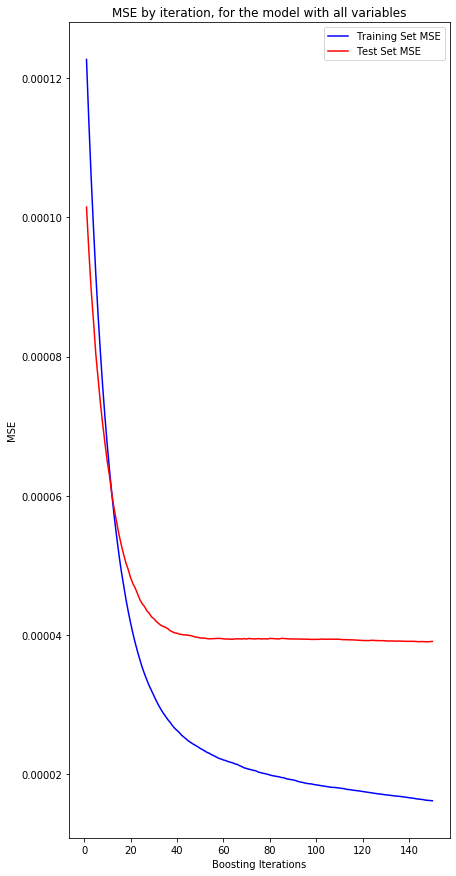

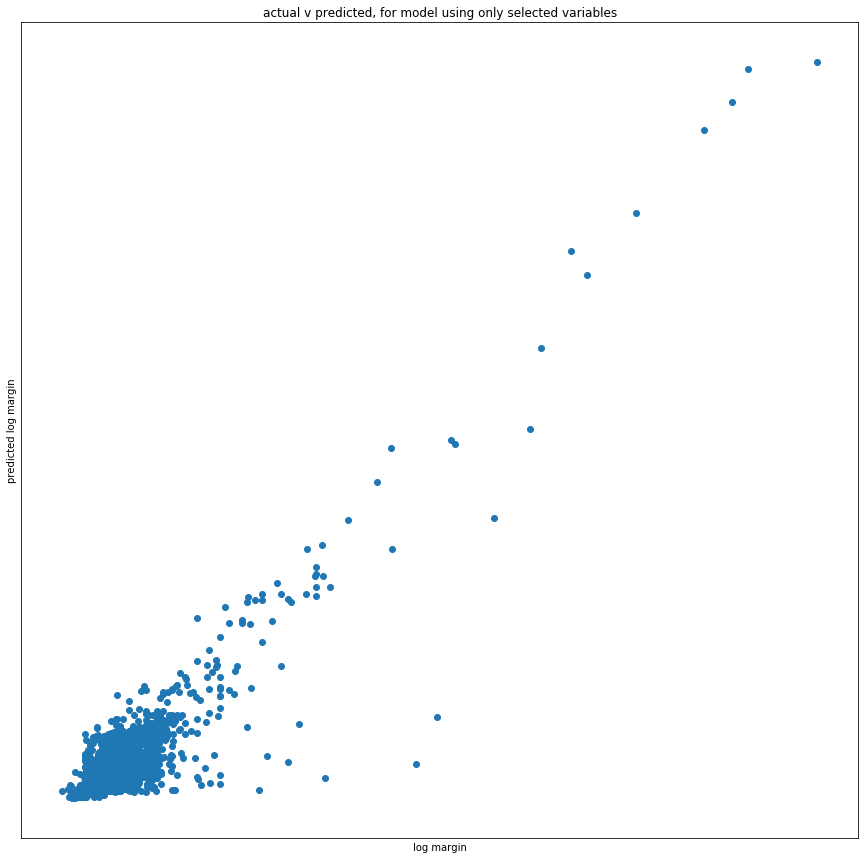

Text(0, 0.5, 'MSE')

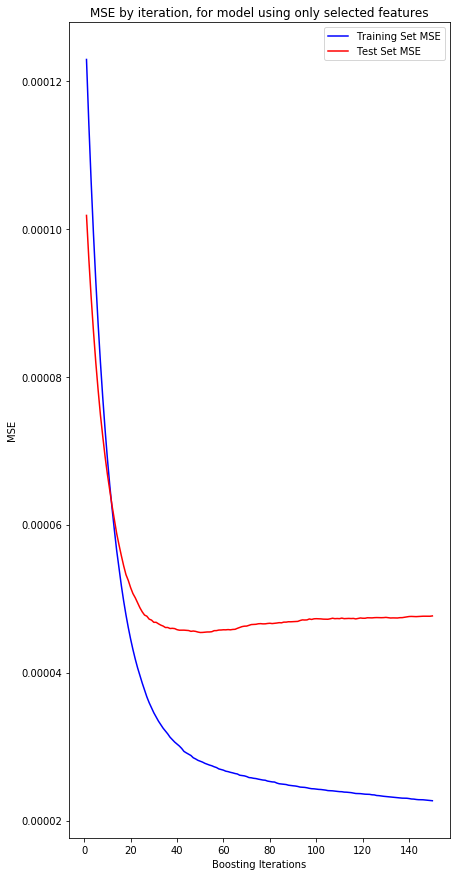

In [113]:
""" Gradient Boosting """
params = {'n_estimators': 150, 'learning_rate': 0.05, 'min_samples_split': 10,  'max_depth': 5, 'loss': 'ls'}

model7 = GradientBoostingRegressor(**params)

""" switch the order of X and Y for the fit to work with GradientBoosting """
""" also, note that we are starting with the full training data, and not the selected variables from above """
result = model7.fit(x_train_df, y_train_array)

""" returns mean accuracy"""
accuracy = model7.score(x_test_df, y_test_df)
print("GB overall accuracy, for model with all variables:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model7.predict(x_train_df)), columns=["P_log_margin_Y_pos_1"])
predict_test = pd.DataFrame(np.copy(model7.predict(x_test_df)), columns=["P_log_margin_Y_pos_1"])

print(" ") 
print("MSE train, for model with all variables:", mean_squared_error(y_train_array, predict_train))
print("MSE test, for model with all variables:", mean_squared_error(y_test_array, predict_test))

# Plot feature importance
feature_importance = result.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,50))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance, for model with all variables')
plt.show()

""" plotting MSE with each iteration for the model with all variables """

test_MSE  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_MSE = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model7.staged_predict(x_test_df)):
    test_MSE[i] = mean_squared_error(y_test_array, y_pred)

for i, y_pred in enumerate(model7.staged_predict(x_train_df)):
    train_MSE[i] = mean_squared_error(y_train_array, y_pred)

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('MSE by iteration, for the model with all variables')
plt.plot(np.arange(params['n_estimators']) + 1, train_MSE, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_MSE, 'r-',
         label='Test Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MSE')

""" select only impactful features """
""" note:  decrease/increase this threshold (a relative number between 0 and 100) to select more/less features """
selected_features = (feature_importance > 5)

""" creating a dataframe of independent variables, from the training (and test) data """
"""     having only those independent variables selected above """

x_train_selected_df = x_train_df[x_train_df.columns[selected_features]]
x_test_selected_df = x_test_df[x_test_df.columns[selected_features]]

""" we are also reducing columns in churners data, as this is our final model """
"""     and any data we want to score needs to have the correct columns """
x_churners_selected_df = x_churners_df[x_churners_df.columns[selected_features]]

""" refitting the model using a subset of features """
""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result = model7.fit(x_train_selected_df, y_train_array)
""" returns mean accuracy"""
accuracy = model7.score(x_test_selected_df, y_test_df)
print("GB overall accuracy, for model with only selected features:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model7.predict(x_train_selected_df)), columns=["P_log_margin_Y_pos_1"])
predict_test = pd.DataFrame(np.copy(model7.predict(x_test_selected_df)), columns=["P_log_margin_Y_pos_1"])
predict_churners = pd.DataFrame(np.copy(model7.predict(x_churners_selected_df)), columns=["P_log_margin_Y_pos_1"])

print(" ") 
print("MSE train, for model with only selected features:", mean_squared_error(y_train_array, predict_train))
print("MSE test, for model with only selected features:", mean_squared_error(y_test_array, predict_test))

plt.figure(figsize=(15,15))
plt.scatter(y_train_array, predict_train)
plt.xlabel("log margin")
plt.ylabel("predicted log margin")
plt.title("actual v predicted, for model using only selected variables")
plt.xticks([])
plt.yticks([])
print(" ") 
plt.show()

""" plotting MSE with each iteration """

test_MSE  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_MSE = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model7.staged_predict(x_test_selected_df)):
    test_MSE[i] = mean_squared_error(y_test_array, y_pred)

for i, y_pred in enumerate(model7.staged_predict(x_train_selected_df)):
    train_MSE[i] = mean_squared_error(y_train_array, y_pred)

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('MSE by iteration, for model using only selected features')
plt.plot(np.arange(params['n_estimators']) + 1, train_MSE, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_MSE, 'r-',
         label='Test Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MSE')

### Feature Importance for the Gradient Boosting Model:

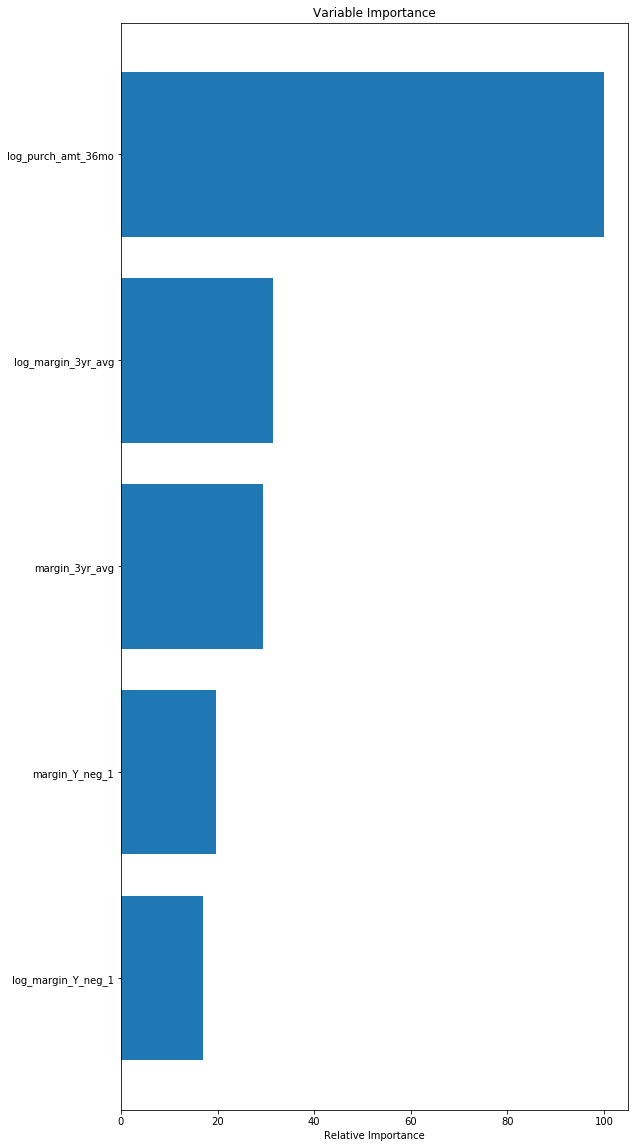

In [114]:
feature_importance = model7.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Appending the train and test sets, and keeping the acct_IDs and predicted churn probabilities

In [115]:
""" append together train and test predicted values, keeping only acct ID and predicted values """
""" also predicting values for the held-out churners and appending those, so we have all rows """

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)
y_churners_df = y_churners_df.reset_index(drop=True)

""" joining predicted and actuals """
""" NOTE:  for reference, for now...to be used more later to create complete """
"""     dataframe with all obs and inputs and outputs """

train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

churners_accounts = churners_acct_IDs_df.reset_index(drop=True)
pred_v_actual_churners = y_churners_df.join(predict_churners)
pred_v_actual_churners = pred_v_actual_churners.join(churners_accounts)

""" appending test to train, and calling it train """
pred_v_actual_train=pred_v_actual_train.append(pred_v_actual_test, ignore_index=True)
""" appending churners to train, and calling it train """
pred_v_actual_train=pred_v_actual_train.append(pred_v_actual_churners, ignore_index=True)

""" dropping the actuals and keeping just the predicted values """
pred_v_actual_train = pred_v_actual_train.drop(['log_margin_Y_pos_1'
                             ],axis=1)

""" and then save predicted values by acct ID to csv """

pred_v_actual_train.to_csv(r'margin_scores.csv',index=False)
pred_v_actual_train.shape

(239356, 2)

## Start of Step 4

#### Reading in the original data, and joining with the churn and margin predicted values:

In [116]:
combined_df.shape

(239356, 147)

In [117]:
churn_df = pd.read_csv(r'churn_scores.csv')
margin_df = pd.read_csv(r'margin_scores.csv')

combined_df = pd.merge(combined_df, churn_df, on='acct_ID', how='left')
combined_df = pd.merge(combined_df, margin_df, on='acct_ID', how='left')

# it should be noted that Python is case sensitive for variable names.  acct_id above would fail.

combined_df.shape

(239356, 149)

In [118]:
combined_df.columns

Index(['ST', 'Zip', 'DMA', 'Area_Cd', 'emailable', 'solicit_ph_ind', 'solicit_email_ind', 'fixd_incm_flg', 'scheduled_purchase_flg', 'months_since_last_trans',
       ...
       'demog_inc_crs_$  30000 - $  39999', 'demog_inc_crs_$  40000 - $  49999', 'demog_inc_crs_$  50000 - $  74999', 'demog_inc_crs_$  75000 - $  99999', 'demog_inc_crs_$ 100000 - $149999', 'demog_inc_crs_$ 150000 - $199999', 'demog_inc_crs_$ 200000 or more', 'demog_inc_crs_Less than $15000', 'P_churn_year_plus1_ind', 'P_log_margin_Y_pos_1'], dtype='object', length=149)

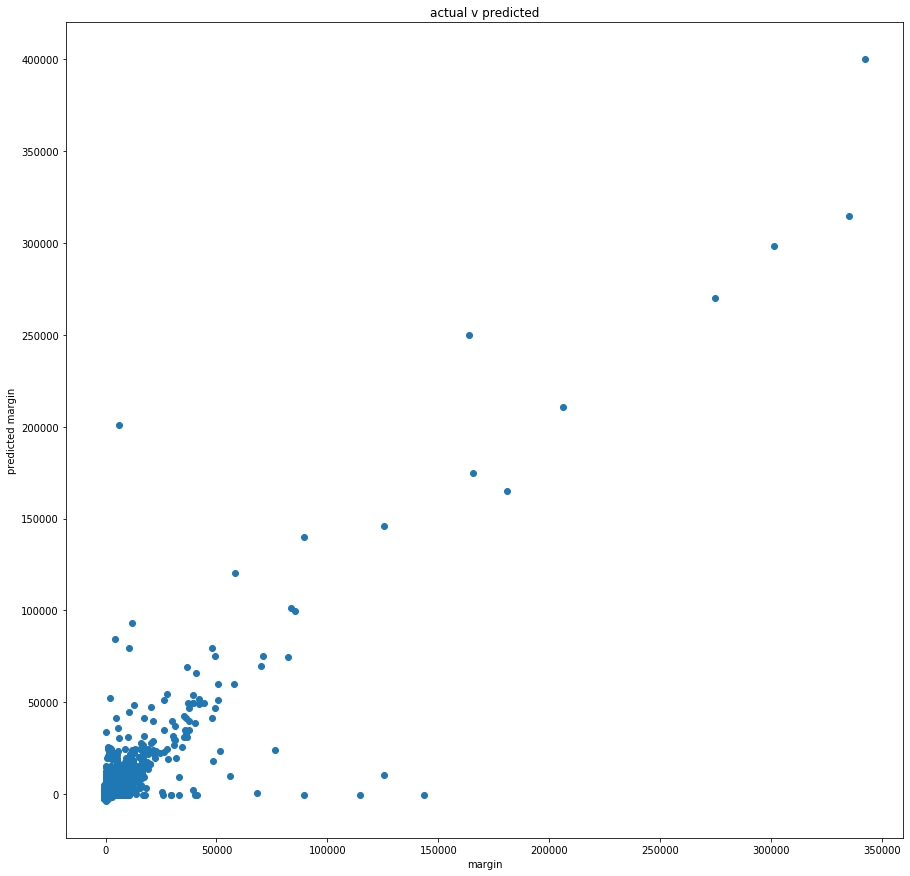

In [119]:
combined_df['P_margin_Y_pos_1']=10**combined_df['P_log_margin_Y_pos_1']-50000

# Plotting predicted untransformed values vs actual untransformed values:

plt.figure(figsize=(15,15))
plt.scatter(combined_df['P_margin_Y_pos_1'], combined_df['margin_Y_pos_1'])
plt.xlabel("margin")
plt.ylabel("predicted margin")
plt.title("actual v predicted")
# plt.xticks([])
# plt.yticks([])
print(" ") 
plt.show()

### It should be noted:  we are scoring our original data, used for modeling, only for the purposes of analysis.
##  In a "real world" situation, we would most likely be scoring a full population for which we did not actually
##  know the future churn or the future margin.

### We are using a simplified CLV formula, in which we:
###    *  are predicting only annual numbers,
###    *  are assuming that next year's annual prediction are the same values for the next 3 years,
###    *  that our future value is adequately estimated using only 3 future years.

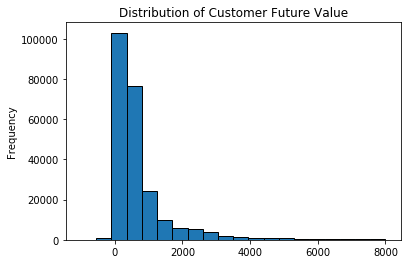

,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,churn_year_plus1_ind,log_order_cnt_36mo,log_purch_amt_36mo,log_purch_amt_life,log_purch_avg_36mo,log_purch_cnt_life,log_purch_cnt_tt_36mo,log_resp_cnt_36mo,perc_purch_cc_36mo,perc_purch_ck_36mo,perc_purch_et_36mo,margin_Y_neg_1,margin_Y_neg_2,margin_Y_neg_3,...,demog_LOR_20+ years,demog_ownrent_Definite Owner,demog_ownrent_Definite Renter,demog_ownrent_Probable Owner,demog_ownrent_Probable Renter,demog_age_18-24 years old,demog_age_25-34 years old,demog_age_35-44 years old,demog_age_45-54 years old,demog_age_55-64 years old,demog_age_65-74 years old,demog_age_75+ years old,demog_inc_crs_$ 15000 - $ 29999,demog_inc_crs_$ 30000 - $ 39999,demog_inc_crs_$ 40000 - $ 49999,demog_inc_crs_$ 50000 - $ 74999,demog_inc_crs_$ 75000 - $ 99999,demog_inc_crs_$ 100000 - $149999,demog_inc_crs_$ 150000 - $199999,demog_inc_crs_$ 200000 or more,demog_inc_crs_Less than $15000,P_churn_year_plus1_ind,P_log_margin_Y_pos_1,P_margin_Y_pos_1,CFV
count,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,...,239356.00,239356.00,239356.00,239356.00,239356.00,2.39e+05,239356.00,239356.00,239356.0,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,239356.00,2.39e+05,2.39e+05,239356.00,2.39e+05,2.39e+05,239356.00,239356.00
mean,0.52,0.89,0.96,0.09,0.26,2.91,65.63,4.92,19.06,7.79,2.27,0.26,0.74,2.60,2.86,1.54,1.40,1.14,0.32,0.31,0.56,0.13,221.44,189.04,165.86,...,0.25,0.64,0.02,0.02,0.02,5.45e-03,0.06,0.14,0.2,0.23,0.18,0.13,0.25,0.15,0.11,0.17,0.08,0.06,9.96e-03,5.06e-03,0.09,2.63e-01,4.70e+00,414.47,814.78
std,0.50,0.31,0.19,0.29,0.44,3.11,58.18,10.07,14.79,47.48,2.37,0.44,0.29,0.65,0.80,0.35,0.60,0.43,0.45,0.44,0.47,0.32,1532.90,1925.40,2133.71,...,0.43,0.48,0.15,0.13,0.15,7.36e-02,0.23,0.35,0.4,0.42,0.39,0.34,0.43,0.36,0.32,0.37,0.27,0.24,9.93e-02,7.09e-02,0.29,3.17e-01,8.81e-03,1881.03,3699.66
min,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.00,0.00,0.00,0.00,0.00,-15084.25,-21224.13,-7515.94,...,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00,4.71e-03,4.69e+00,-712.55,-1692.27
25%,0.00,1.00,1.00,0.00,0.00,1.00,14.00,1.00,6.00,0.00,1.00,0.00,0.60,2.21,2.34,1.32,0.95,0.85,0.00,0.00,0.00,0.00,42.28,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00,1.59e-02,4.70e+00,156.21,113.79
50%,1.00,1.00,1.00,0.00,0.00,1.00,46.00,1.22,16.00,0.00,2.00,0.00,0.70,2.71,2.91,1.42,1.43,1.26,0.00,0.00,0.93,0.00,182.34,126.43,29.07,...,0.00,1.00,0.00,0.00,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00,9.18e-02,4.70e+00,195.93,397.20
75%,1.00,1.00,1.00,0.00,1.00,4.00,110.00,2.59,33.00,3.00,3.00,1.00,0.90,3.03,3.43,1.68,1.87,1.53,0.60,0.93,1.00,0.00,337.79,295.52,246.36,...,0.00,1.00,0.00,0.00,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00,5.16e-01,4.70e+00,388.10,788.40
max,1.00,1.00,1.00,1.00,1.00,12.00,290.00,168.00,424.00,2670.00,38.00,1.00,2.78,6.09,6.74,5.48,3.42,2.68,2.61,2.00,2.00,1.08,284605.19,469878.25,493368.29,...,1.00,1.00,1.00,1.00,1.00,1.00e+00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00e+00,1.00e+00,1.00,9.56e-01,5.59e+00,342356.24,744919.17


In [120]:
annual_discount_rate = 0.10
combined_df['CFV'] = (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**1))/((1+annual_discount_rate)**1) + (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**2))/((1+annual_discount_rate)**2) + (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**3))/((1+annual_discount_rate)**3)
plothist = combined_df['CFV'].plot.hist(title="Distribution of Customer Future Value",bins=20, range=(-1000,8000),edgecolor='black')
plt.show()
combined_df.describe()

### Establishing the quadrants for high/low churn and margin

In [122]:
combined_df.dtypes

ST                                    object
Zip                                   object
DMA                                   object
Area_Cd                               object
emailable                              int64
solicit_ph_ind                         int64
solicit_email_ind                      int64
fixd_incm_flg                          int64
scheduled_purchase_flg                 int64
months_since_last_trans                int64
months_since_first_trans               int64
purch_avg_interval                   float64
mail_cnt_36mo                          int64
call_in_mo_36mo                        int64
call_out_mo_36mo                       int64
tier                                  object
tier_prev                             object
acct_ID                               object
activation_date                       object
event_date                            object
churn_year_plus1_ind                   int64
log_order_cnt_36mo                   float64
log_purch_

In [125]:
print("median predicted churn: ",  np.median(combined_df['P_churn_year_plus1_ind']))
print("median predicted margin: %d" % (np.median(combined_df['P_margin_Y_pos_1'])))

# initializing to values which should not occur after logic below.
combined_df['retention_grp'] = '0X'
combined_df['margin_grp'] = '0X'
combined_df['quadrant_retention_margin'] = 'error_error'

combined_df.loc[combined_df['P_churn_year_plus1_ind']<np.median(combined_df['P_churn_year_plus1_ind']),'retention_grp']="2H"
combined_df.loc[combined_df['P_churn_year_plus1_ind']>=np.median(combined_df['P_churn_year_plus1_ind']),'retention_grp']="1L"

combined_df.loc[(combined_df['P_margin_Y_pos_1']<np.median(combined_df['P_margin_Y_pos_1'])),'margin_grp']="1L"
combined_df.loc[(combined_df['P_margin_Y_pos_1']>=np.median(combined_df['P_margin_Y_pos_1'])),'margin_grp']="2H"

combined_df.loc[(combined_df['retention_grp'] == '1L') & (combined_df['margin_grp'] == '1L'),'quadrant_retention_margin'] = "1L_1L"
combined_df.loc[(combined_df['retention_grp'] == '1L') & (combined_df['margin_grp'] == '2H'),'quadrant_retention_margin'] = "1L_2H"
combined_df.loc[(combined_df['retention_grp'] == '2H') & (combined_df['margin_grp'] == '1L'),'quadrant_retention_margin'] = "2H_1L"
combined_df.loc[(combined_df['retention_grp'] == '2H') & (combined_df['margin_grp'] == '2H'),'quadrant_retention_margin'] = "2H_2H"

combined_df.head(10)

median predicted churn:  0.09183166308462808
median predicted margin: 195


,ST,Zip,DMA,Area_Cd,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,tier,tier_prev,acct_ID,activation_date,event_date,churn_year_plus1_ind,log_order_cnt_36mo,log_purch_amt_36mo,log_purch_amt_life,log_purch_avg_36mo,...,demog_ownrent_Probable Owner,demog_ownrent_Probable Renter,demog_age_18-24 years old,demog_age_25-34 years old,demog_age_35-44 years old,demog_age_45-54 years old,demog_age_55-64 years old,demog_age_65-74 years old,demog_age_75+ years old,demog_inc_crs_$ 15000 - $ 29999,demog_inc_crs_$ 30000 - $ 39999,demog_inc_crs_$ 40000 - $ 49999,demog_inc_crs_$ 50000 - $ 74999,demog_inc_crs_$ 75000 - $ 99999,demog_inc_crs_$ 100000 - $149999,demog_inc_crs_$ 150000 - $199999,demog_inc_crs_$ 200000 or more,demog_inc_crs_Less than $15000,P_churn_year_plus1_ind,P_log_margin_Y_pos_1,P_margin_Y_pos_1,CFV,retention_grp,margin_grp,quadrant_retention_margin
0,SC,29607,567,864,1,1,1,0,0,3,21,4.50,5,0,1,1-Bronze,xxx,I148760611,30NOV12,31MAY15,1,0.30,2.16,2.16,1.48,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,6.81e-01,4.7,94.84,37.83,1L,1L,1L_1L
1,MO,63901,632,573,1,1,1,0,0,9,9,36.00,1,1,0,1-Bronze,xxx,I151076142,29NOV13,29NOV14,1,0.30,1.32,1.32,1.32,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8.69e-01,4.7,97.32,13.09,1L,1L,1L_1L
2,IL,60456,602,missing,0,1,1,0,0,1,167,3.07,17,0,0,1-Bronze,xxx,I27001315,05OCT00,NaN,0,0.70,2.78,3.46,1.56,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4.16e-02,4.7,339.19,777.30,2H,2H,2H_2H
3,FL,34698,539,727,1,1,1,0,0,9,13,1.00,5,1,1,3-Gold,xxx,I150064127,31JUL13,29NOV14,1,0.60,2.62,2.62,1.93,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,9.03e-01,4.7,309.05,29.86,1L,2H,1L_2H
4,CA,92084,825,760,0,1,1,0,0,1,2,1.00,2,0,0,1-Bronze,xxx,I152631565,30JUN14,NaN,0,0.48,2.08,2.08,1.79,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1.17e-01,4.7,172.69,338.96,1L,1L,1L_1L
5,MI,48446,505,810,1,0,1,0,0,11,128,1.58,4,0,3,1-Bronze,2-Silver,H62972005,04JAN04,30SEP14,1,0.78,2.49,3.30,1.89,...,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,5.32e-01,4.7,214.52,146.49,1L,2H,1L_2H
6,AL,35020,630,205,0,1,1,0,0,5,10,1.00,6,0,0,1-Bronze,xxx,I151044258,30OCT13,31MAR15,1,0.30,2.08,2.08,1.32,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,8.60e-01,4.7,172.69,25.13,1L,1L,1L_1L
7,PR,missing,998,missing,0,1,1,0,1,1,121,2.07,30,0,0,1-Bronze,xxx,I95584028,04AUG04,NaN,0,0.48,2.78,3.08,1.32,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.74e-03,4.7,199.20,488.95,2H,2H,2H_2H
8,AZ,85232,753,520,1,1,1,0,1,1,120,19.83,4,0,0,3-Gold,1-Bronze,I106802847,03SEP04,NaN,0,0.48,1.91,2.42,1.32,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1.13e-02,4.7,162.11,394.40,2H,1L,2H_1L
9,CA,95691,862,916,1,1,1,0,0,12,15,1.00,4,1,2,1-Bronze,xxx,I149698399,31MAY13,30AUG14,1,0.48,1.96,1.96,1.37,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.89e-01,4.7,141.90,15.90,1L,1L,1L_1L


### Output scored data and go to Tableau for more analysis...

In [126]:
combined_df.to_csv(r'CLV_scores.csv',index=False)

In [127]:
print("number of accounts, in each quadrant")
print(combined_df.groupby(['margin_grp', 'retention_grp'])['acct_ID'].count().apply("{:,}".format))

print("")  # intentional blank line for spacing

print("percentage of accounts with scheduled purchase, in each quadrant")
print(combined_df.groupby(['margin_grp', 'retention_grp'])['scheduled_purchase_flg'].mean().apply("{:.1%}".format))

number of accounts, in each quadrant
margin_grp  retention_grp
1L          1L               83,439
            2H               24,281
2H          1L               36,239
            2H               95,397
Name: acct_ID, dtype: object

percentage of accounts with scheduled purchase, in each quadrant
margin_grp  retention_grp
1L          1L                0.4%
            2H               66.9%
2H          1L                0.3%
            2H               47.7%
Name: scheduled_purchase_flg, dtype: object


In [128]:
# using an agg function to summarize multiple metrics and create a dataframe for output to a .csv
#   (this could be something you want to do for your team project work)

pivot_df = combined_df.groupby(['margin_grp', 'retention_grp']).agg({"acct_ID":"count", "mail_cnt_36mo":"mean", "purch_avg_interval":"median"})

# renaming columns in the pivot-table-like dataframe:
pivot_df = pivot_df.rename(columns={"acct_ID":"number of accounts", "mail_cnt_36mo":"average mail cnt", "purch_avg_interval":"purchase interval median"})

pivot_df.head(10)

number of accounts  average mail cnt  purchase interval median
margin_grp retention_grp                                                                
1L         1L                          83439              8.27                      2.25
           2H                          24281             12.59                      1.35
2H         1L                          36239             17.24                      1.28
           2H                          95397             30.83                      1.02

In [129]:
# saving this pivot-table summary as a .csv
pivot_df.to_csv(r'pivot_table_1.csv', index=True)